1.	Data Preparation (10 points) <br>
(a)	Data cleansing and transformation (5 points) <br>
(b)	Data splitting (i.e., training, validation, and test splits) (5 points) <br>
2.	Exploratory Data Analysis (EDA) (10 points) <br>
(a)	Descriptive statistics (e.g., class distributions, data statistics) (5 points) <br>
(b)	Data visualization (e.g., plot examples from classes, dimensionality reduction approach to shows data) (5 points) <br>
3.	Model Selection (20 points) <br>
(a)	Algorithm selection: Justification for choosing specific data min-ing algorithm (e.g., decision trees, KNN, neural networks, etc.). (5 points) <br>
(b)	Model building: Developing and tuning selected model (e.g., hyper-parameter tuning) (10 points) <br>
(c)	Model evaluation: Proper evaluation metrics (e.g., accuracy, preci-sion, recall, F1-score) and qualitative analysis (e.g., confusion matri-ces) for classification on test set. (5 points) <br>
4.	Code and Software (10 points) <br>
(a)	Code quality (i.e., well-documented, readable, and structured code)(5 points) <br>
(b)	Ability to run code (5 points) <br>
5.	Collaboration (10 points) <br>
(a)	Teamwork: Each individual will provide a ranking for their team members: excellent, very good, satisfactory, needs improvement, and unsatisfactory. Justification will be needed for rankings less than satisfactory. This will be submitted individually on Canvas. (5 points per team member) <br>
6.	Interpretability (10 point) <br>
(a)	Model interpretablity: Demonstrating an understanding of how the model makes predictions (e.g., feature importance). (5 points) <br>
(b)	Business insights: Discussion of the practical implications of this work for a clothing company. (5 points) <br>
7.	Project Report (30 points) <br>
(a)	This component will be graded based on the requirements outlined above. <br>
8.	(Optional) Accessible Work (5 points) <br>
(a)	Website or blog post to share work completed on project. <br>

Notebook Contributor: Ching-Yao Lin

# 1. Project setup

In [1]:
# Data cleaning and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

# Deep learning
import torch
import torch.nn as nn
from torchsummary import summary

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

# Machine learning
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import ParameterGrid

# Housekeepings
from tqdm import tqdm
import os
import random
import pickle
import itertools
from collections import namedtuple

# Notebook Setups
from IPython.display import display, HTML
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
pd.set_option('display.max_columns', None)

In [2]:
from google.colab import drive
drive.mount("/content/drive/")

os.chdir("drive/Shareddrives/ECEN758 Group Jarvis")

Mounted at /content/drive/


In [3]:
# Helper functions
def print_colored_text(text, background_color="white", font_color="black", bold=False):
    font_weight = "bold" if bold else "normal"
    html_code = f'<div style="background-color: {background_color}; color: {font_color}; font-weight: {font_weight}; padding: 10px; display: inline-block;">{text}</div>'
    display(HTML(html_code))

def set_seed(seed: int = 42) -> None:
    """Set random seeds for used packages"""
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ["PYTHONHASHSEED"] = str(seed)

    return None

In [4]:
# Set up the device for pytorch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# Set the random seeds for all packages
SEED = 42
set_seed(SEED)

# Load the FashionMNIST dataset from PyTorch
train_set = torchvision.datasets.FashionMNIST(root="data", download=True, train=True,
                                              transform=transforms.Compose([transforms.ToTensor()]))
test_set = torchvision.datasets.FashionMNIST(root="data", download=True, train=False,
                                             transform=transforms.Compose([transforms.ToTensor()]))

# Print the shape of train/test features/labels
print(train_set.data.shape)
print(train_set.targets.shape)
print(test_set.data.shape)
print(test_set.targets.shape)

cuda:0
torch.Size([60000, 28, 28])
torch.Size([60000])
torch.Size([10000, 28, 28])
torch.Size([10000])


# 2. Exploratory Data Analysis (EDA)

In [5]:
# Get the name of the labels
labels_map = {v: k for k, v in train_set.class_to_idx.items()}
labels_list = train_set.classes
print(labels_map)  # A dictionary mapping integer labels to readable label names
print(labels_list) # A list of label names with their indices being their corresponding integer labels

{0: 'T-shirt/top', 1: 'Trouser', 2: 'Pullover', 3: 'Dress', 4: 'Coat', 5: 'Sandal', 6: 'Shirt', 7: 'Sneaker', 8: 'Bag', 9: 'Ankle boot'}
['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


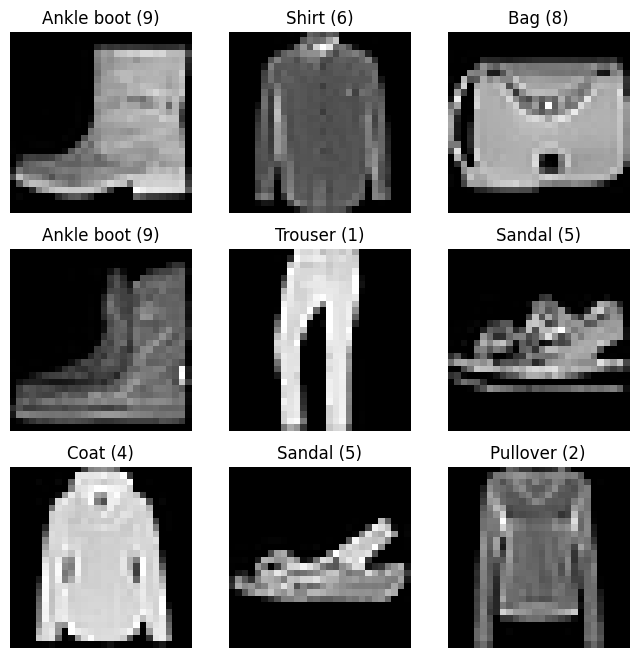

In [ ]:
# Sample and plot images
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_set.data), size=(1,)).item()
    img, label = train_set.data[sample_idx], train_set.targets[sample_idx].item()
    _ = figure.add_subplot(rows, cols, i)
    _ = plt.title(f"{labels_map[label]} ({label})")
    _ = plt.axis("off")
    _ = plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [ ]:
# Distribution of classes: Very balanced
pd.Series(train_set.targets.numpy()).value_counts().sort_index().to_frame().T

,0,1,2,3,4,5,6,7,8,9
0,6000,6000,6000,6000,6000,6000,6000,6000,6000,6000


<Axes: ylabel='Frequency'>

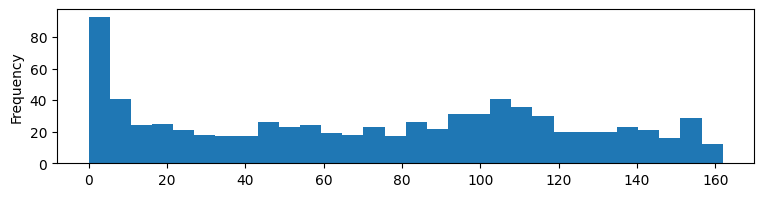

In [ ]:
# Distribution of colors used: Many are 0s or around 100
pd.Series(train_set.data.float().mean(dim=0).flatten().numpy()).plot(kind='hist', bins=30, figsize=(9, 2))

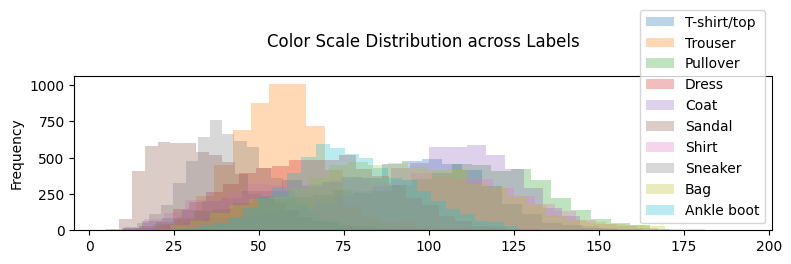

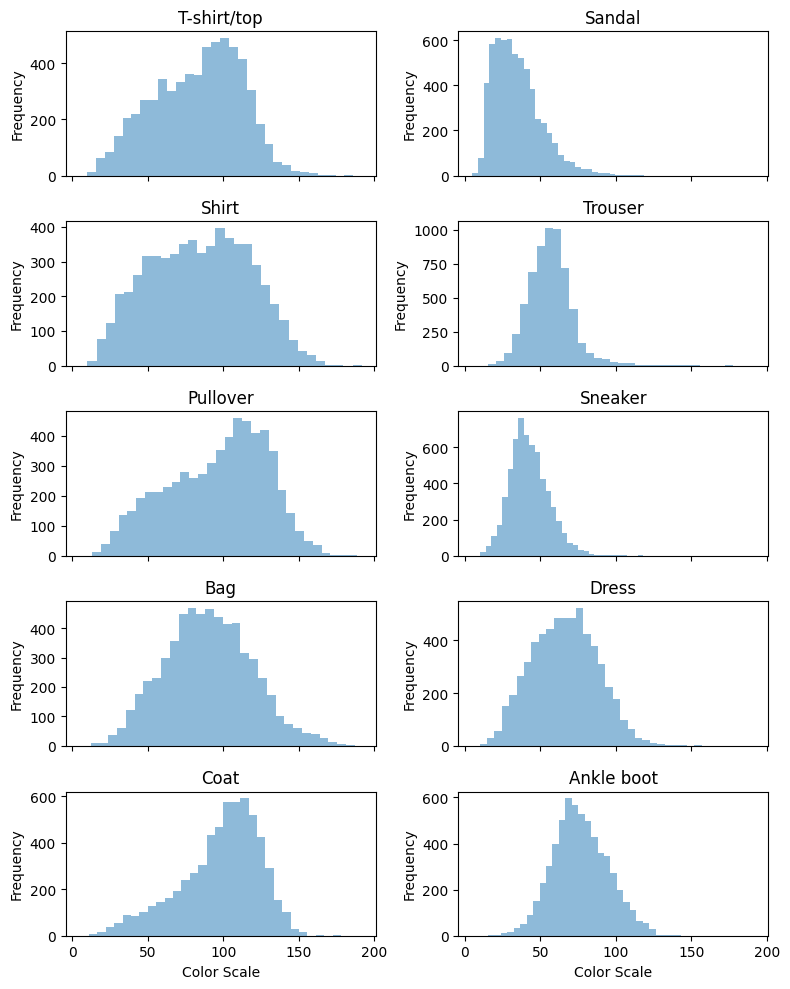

In [ ]:
# Distribution of the mean of gray-scaled colors (for each label)
flatten_images = train_set.data.reshape(len(train_set.data), -1).float().numpy()
labels = train_set.targets.reshape(len(train_set.data), -1).float().numpy()
df = pd.DataFrame(np.c_[flatten_images, labels], columns=list(range(flatten_images.shape[1]))+['label'])

all_fig, all_ax = plt.subplots(nrows=1, ncols=1, figsize=(9, 2))
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(8, 10), sharex=True)
for i, (label, group_df) in enumerate(df.groupby('label')):
    all_ax = group_df.mean(axis=1).plot(kind='hist', bins=30, alpha=0.3, ax=all_ax,
                                        legend=True, label=labels_map[label], title="Color Scale Distribution across Labels\n")
    group_ax = group_df.mean(axis=1).plot(kind='hist', bins=30, alpha=0.5, title=labels_map[label], ax=axes[i%5][i%2])
    _ = group_ax.set_xlabel('Color Scale')
    _ = plt.setp(group_ax.get_xticklabels(), visible=True)
    plt.tight_layout();

# 3. Data Preparation & Model Definition

In [6]:
# Define PyTorch Dataset to combine X and y
class CombineDataset(Dataset):

    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [7]:
class FashionMLP(nn.Module):

    def __init__(self):
        super(FashionMLP, self).__init__()

        self.layers = nn.Sequential(
            nn.Linear(in_features=28 * 28, out_features=400),
            nn.Linear(in_features=400, out_features=150),
            nn.Linear(in_features=150, out_features=10)
        )

    def forward(self, x):
        x = x.view(len(x), -1)
        return self.layers(x)

In [8]:
class FashionCNN(nn.Module):

    def __init__(self):
        super(FashionCNN, self).__init__()

        self.layer1 = nn.Sequential(                                                # x is [bs, 1, 28, 28]
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),    # Size([bs, 32, 28, 28])
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),                                                        # Size([bs, 32, 14, 14])
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),              # Size([bs, 64, 12, 12])
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)                                                         # Size([bs, 64, 6, 6])
        )

        self.output_layers = nn.Sequential(
            nn.Linear(in_features=64 * 6 * 6, out_features=600),                    # Size([bs, 600])
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(in_features=600, out_features=120),                           # Size([bs, 120])
            nn.Linear(in_features=120, out_features=10),                            # Size([bs, 10])
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.output_layers(out)

        return out

In [9]:
model = FashionCNN()
summary(model.to(device), input_size=(1, 28, 28))
del model

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
       BatchNorm2d-2           [-1, 32, 28, 28]              64
              ReLU-3           [-1, 32, 28, 28]               0
         MaxPool2d-4           [-1, 32, 14, 14]               0
            Conv2d-5           [-1, 64, 12, 12]          18,496
       BatchNorm2d-6           [-1, 64, 12, 12]             128
              ReLU-7           [-1, 64, 12, 12]               0
         MaxPool2d-8             [-1, 64, 6, 6]               0
            Linear-9                  [-1, 600]       1,383,000
             ReLU-10                  [-1, 600]               0
          Dropout-11                  [-1, 600]               0
           Linear-12                  [-1, 120]          72,120
           Linear-13                   [-1, 10]           1,210
          Softmax-14                   

# 4. Model Training & Cross Validation

## Functions for training & cross validation

In [10]:
# Hyperparameter definition
Params = namedtuple("Params", ["num_epochs", "learning_rate", "batch_size", "max_early_stop"])

In [11]:
def train(model, train_loader, val_loader, hyperparameters, save_path, loss_fn=torch.nn.CrossEntropyLoss(), val=True, show_tqdm=False, verbose=False):

    # Parse out the hyperparameters
    num_epochs = hyperparameters.num_epochs
    learning_rate = hyperparameters.learning_rate
    max_early_stop = hyperparameters.max_early_stop

    # Data to record for all epochs
    train_records = {
        "loss": [],
        "accuracy": [],
        "report": [],
    }

    val_records = {
        "loss": [],
        "accuracy": [],
        "report": [],
    }

    # Model setup
    print(f"device={device}")
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Model training
    early_stop_count = 0
    min_loss = np.inf

    for epoch_i in range(num_epochs):

        # Switch to train mode
        model.train()

        # Records within each training epoch
        train_running_loss = 0
        train_total_correct = 0
        train_y_true = []
        train_y_pred = []

        # Training Epoch
        set_seed()
        train_progress_bar = tqdm(train_loader) if show_tqdm else train_loader
        for batch_i, (train_images, train_labels) in enumerate(train_progress_bar, start=1):

            # Send images and labels to GPU if available
            train_images, train_labels = train_images.to(device), train_labels.to(device)

            # Cast dtype to torch.float (from unsigned char) & Add additional dim for channels
            train_images = train_images.view(train_images.size(0), 1, 28, 28).to(torch.float)

            # Zero the gradients to avoid mixing of gradients among batches
            optimizer.zero_grad()

            # Forward pass
            train_outputs = model(train_images)

            # Compute loss
            loss = loss_fn(train_outputs, train_labels)
            train_running_loss += loss.item()

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            # Make predictions on training set
            _, train_predicted = torch.max(train_outputs.detach(), 1) # get the index of the class with the highest probability
            train_total_correct += (train_predicted == train_labels).sum().item()

            # Collect predictions and labels
            train_y_true.extend(train_labels.cpu().numpy())
            train_y_pred.extend(train_predicted.cpu().numpy())

        # Calculate metrics
        epoch_loss = train_running_loss / len(train_loader) # loss per batch
        epoch_accuracy = train_total_correct / len(train_loader.dataset) # Overall train accuracy
        epoch_report = classification_report(train_y_true, train_y_pred, output_dict=True, zero_division=0)

        # Record metrics
        train_records["loss"].append(epoch_loss)
        train_records["accuracy"].append(epoch_accuracy)
        train_records["report"].append(epoch_report)

        # =======================================================================

        # Switch to eval mode
        model.eval()

        # Records within each validation epoch
        val_running_loss = 0
        val_total_correct = 0
        val_y_true = []
        val_y_pred = []

        with torch.no_grad():

            # Validation epoch
            set_seed()
            val_progress_bar = tqdm(val_loader) if show_tqdm else val_loader
            for val_images, val_labels in val_progress_bar:

                # Send images and labels to GPU if available
                val_images, val_labels = val_images.to(device), val_labels.to(device)

                # Cast dtype to torch.float (from unsigned char)
                val_images = val_images.view(val_images.size(0), 1, 28, 28).to(torch.float)

                # Make predictions on validation set
                val_outputs = model(val_images)
                _, val_predicted = torch.max(val_outputs.detach(), 1)
                val_total_correct += (val_predicted == val_labels).sum().item()

                # Compute loss
                loss = loss_fn(val_outputs, val_labels)
                val_running_loss += loss.item()

                # Collect predictions and labels
                val_y_true.extend(val_labels.cpu().numpy())
                val_y_pred.extend(val_predicted.cpu().numpy())


        # Calculate metrics
        val_loss = val_running_loss / len(val_loader) # loss per batch
        val_accuracy = val_total_correct / len(val_loader.dataset) # Overall val accuracy
        val_report = classification_report(val_y_true, val_y_pred, output_dict=True, zero_division=0)
        val_f1 = val_report["macro avg"]["f1-score"]

        # Print current model performance
        if verbose:
            print(f"Epoch[{epoch_i+1}/{num_epochs}]: Train Loss: {epoch_loss:.4f} / Val Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}, Macro F1-Score: {val_f1:.4f} {'***' if val_loss < min_loss else ''}")

        # Record metrics
        val_records["loss"].append(val_loss)
        val_records["accuracy"].append(val_accuracy)
        val_records["report"].append(val_report)

        # Early Stopping
        if val_loss < min_loss:
            min_loss = val_loss
            # Save current model
            torch.save(model.state_dict(), save_path)
            best_model = model
            early_stop_count = 0
        else:
            early_stop_count += 1

        if early_stop_count >= max_early_stop:
            print(f'\nModel is not improving for {max_early_stop} epochs, halt the training session.')
            break

    print("Training finished.")
    return train_records, val_records

In [12]:
def cross_validation(model, train_set, hyperparameters, fold_num=5, verbose=False):

    # Parse out hyperparameters
    print(hyperparameters)
    num_epochs = hyperparameters.num_epochs
    learning_rate = hyperparameters.learning_rate
    batch_size = hyperparameters.batch_size
    max_early_stop = hyperparameters.max_early_stop

    # Stratified K-fold split
    set_seed()
    stratified_kfold = StratifiedKFold(n_splits=fold_num, shuffle=True, random_state=SEED)
    data_splits = stratified_kfold.split(X=train_set.data, y=train_set.targets)

    fold_records = []
    fold_model_save_paths = []
    for fold_i, (train_ids, val_ids) in enumerate(data_splits):
        set_seed()
        if verbose:
            print_colored_text(f"{'= '*35} Fold-{fold_i} {' ='*35}", background_color="MediumSeaGreen", bold=True)

        # Get train/val Dataset for this fold
        X_train = train_set.data[train_ids]
        y_train = train_set.targets[train_ids]
        train_dataset = CombineDataset(X_train, y_train)

        X_val = train_set.data[val_ids]
        y_val = train_set.targets[val_ids]
        val_dataset = CombineDataset(X_val, y_val)

        # Define train/val DataLoaders for this fold
        set_seed()
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

        # Define path to save model
        model_save_path = f"PyTorch_models/{model.__class__.__name__}_fold{fold_i}_lr{learning_rate}_batch{batch_size}_epoch{num_epochs}_earlystop{max_early_stop}"

        # Train the model
        train_records, val_records = train(model, train_loader, val_loader, hyperparameters, model_save_path, verbose=verbose)

        # Save results for this fold
        fold_records.append((train_records, val_records))
        fold_model_save_paths.append(model_save_path)


    del train_loader, val_loader, model, train_records, val_records

    return fold_records, fold_model_save_paths

## 4.1 FashionMLP (training & cross validation)

In [ ]:
# %%time
# # Hyperparameter Set-up
# hyperparameters = Params(num_epochs=3000, learning_rate=0.001, batch_size=100, max_early_stop=100)
# # Instantiate model
# fashion_mlp = FashionMLP().to(device)
# # Print model structures
# print(fashion_mlp)
# # Cross validation
# fashion_mlp_fold_records, fashion_mlp_fold_model_save_paths = cross_validation(fashion_mlp, train_set, hyperparameters, fold_num=5, verbose=True)
# # Delete model (to save memory)
# del fashion_mlp

FashionMLP(
  (layers): Sequential(
    (0): Linear(in_features=784, out_features=400, bias=True)
    (1): Linear(in_features=400, out_features=150, bias=True)
    (2): Linear(in_features=150, out_features=10, bias=True)
  )
)
Params(num_epochs=3000, learning_rate=0.001, batch_size=100, max_early_stop=100)


device=cuda:0
Epoch[1/3000]: Train Loss: 4.2875 / Val Loss: 0.9874, Accuracy: 0.7583, Macro F1-Score: 0.7670 ***
Epoch[2/3000]: Train Loss: 0.8429 / Val Loss: 0.7231, Accuracy: 0.8020, Macro F1-Score: 0.7955 ***
Epoch[3/3000]: Train Loss: 0.7321 / Val Loss: 0.6556, Accuracy: 0.7988, Macro F1-Score: 0.7907 ***
Epoch[4/3000]: Train Loss: 0.6294 / Val Loss: 0.5721, Accuracy: 0.8197, Macro F1-Score: 0.8175 ***
Epoch[5/3000]: Train Loss: 0.5558 / Val Loss: 0.5090, Accuracy: 0.8304, Macro F1-Score: 0.8302 ***
Epoch[6/3000]: Train Loss: 0.5545 / Val Loss: 0.6686, Accuracy: 0.7871, Macro F1-Score: 0.7925 
Epoch[7/3000]: Train Loss: 0.5287 / Val Loss: 0.4918, Accuracy: 0.8402, Macro F1-Score: 0.8357 ***
Epoch[8/3000]: Train Loss: 0.6163 / Val Loss: 0.6878, Accuracy: 0.7937, Macro F1-Score: 0.7849 
Epoch[9/3000]: Train Loss: 0.5387 / Val Loss: 0.5389, Accuracy: 0.8220, Macro F1-Score: 0.8205 
Epoch[10/3000]: Train Loss: 0.5671 / Val Loss: 0.5386, Accuracy: 0.8297, Macro F1-Score: 0.8237 
Epoch[1

device=cuda:0
Epoch[1/3000]: Train Loss: 0.4774 / Val Loss: 0.4412, Accuracy: 0.8537, Macro F1-Score: 0.8543 ***
Epoch[2/3000]: Train Loss: 0.4578 / Val Loss: 0.5537, Accuracy: 0.8171, Macro F1-Score: 0.8117 
Epoch[3/3000]: Train Loss: 2.0372 / Val Loss: 0.5245, Accuracy: 0.8413, Macro F1-Score: 0.8414 
Epoch[4/3000]: Train Loss: 0.4332 / Val Loss: 0.4232, Accuracy: 0.8568, Macro F1-Score: 0.8537 ***
Epoch[5/3000]: Train Loss: 0.4016 / Val Loss: 0.4111, Accuracy: 0.8582, Macro F1-Score: 0.8572 ***
Epoch[6/3000]: Train Loss: 0.3930 / Val Loss: 0.4202, Accuracy: 0.8576, Macro F1-Score: 0.8535 
Epoch[7/3000]: Train Loss: 0.3937 / Val Loss: 0.4126, Accuracy: 0.8566, Macro F1-Score: 0.8553 
Epoch[8/3000]: Train Loss: 0.4000 / Val Loss: 0.4455, Accuracy: 0.8469, Macro F1-Score: 0.8444 
Epoch[9/3000]: Train Loss: 0.4007 / Val Loss: 0.4192, Accuracy: 0.8526, Macro F1-Score: 0.8535 
Epoch[10/3000]: Train Loss: 0.4015 / Val Loss: 0.4565, Accuracy: 0.8333, Macro F1-Score: 0.8339 
Epoch[11/3000]: 

device=cuda:0
Epoch[1/3000]: Train Loss: 0.5470 / Val Loss: 0.4699, Accuracy: 0.8446, Macro F1-Score: 0.8457 ***
Epoch[2/3000]: Train Loss: 0.4869 / Val Loss: 0.4323, Accuracy: 0.8556, Macro F1-Score: 0.8530 ***
Epoch[3/3000]: Train Loss: 0.4466 / Val Loss: 0.4374, Accuracy: 0.8533, Macro F1-Score: 0.8530 
Epoch[4/3000]: Train Loss: 0.4677 / Val Loss: 0.7675, Accuracy: 0.7874, Macro F1-Score: 0.7740 
Epoch[5/3000]: Train Loss: 2.7371 / Val Loss: 0.5845, Accuracy: 0.8436, Macro F1-Score: 0.8398 
Epoch[6/3000]: Train Loss: 0.4710 / Val Loss: 0.4424, Accuracy: 0.8482, Macro F1-Score: 0.8481 
Epoch[7/3000]: Train Loss: 0.4110 / Val Loss: 0.4694, Accuracy: 0.8468, Macro F1-Score: 0.8430 
Epoch[8/3000]: Train Loss: 0.4029 / Val Loss: 0.4146, Accuracy: 0.8603, Macro F1-Score: 0.8566 ***
Epoch[9/3000]: Train Loss: 0.4049 / Val Loss: 0.4266, Accuracy: 0.8538, Macro F1-Score: 0.8492 
Epoch[10/3000]: Train Loss: 0.4058 / Val Loss: 0.4238, Accuracy: 0.8538, Macro F1-Score: 0.8527 
Epoch[11/3000]: 

device=cuda:0
Epoch[1/3000]: Train Loss: 0.5755 / Val Loss: 0.4414, Accuracy: 0.8519, Macro F1-Score: 0.8525 ***
Epoch[2/3000]: Train Loss: 0.4714 / Val Loss: 0.4527, Accuracy: 0.8462, Macro F1-Score: 0.8452 
Epoch[3/3000]: Train Loss: 0.4602 / Val Loss: 0.5265, Accuracy: 0.8349, Macro F1-Score: 0.8317 
Epoch[4/3000]: Train Loss: 0.4965 / Val Loss: 0.4321, Accuracy: 0.8561, Macro F1-Score: 0.8562 ***
Epoch[5/3000]: Train Loss: 0.4442 / Val Loss: 0.4150, Accuracy: 0.8519, Macro F1-Score: 0.8479 ***
Epoch[6/3000]: Train Loss: 5.4468 / Val Loss: 3.3779, Accuracy: 0.8096, Macro F1-Score: 0.8033 
Epoch[7/3000]: Train Loss: 0.9318 / Val Loss: 0.5140, Accuracy: 0.8534, Macro F1-Score: 0.8462 
Epoch[8/3000]: Train Loss: 0.4741 / Val Loss: 0.4521, Accuracy: 0.8580, Macro F1-Score: 0.8583 
Epoch[9/3000]: Train Loss: 0.4358 / Val Loss: 0.4222, Accuracy: 0.8602, Macro F1-Score: 0.8617 
Epoch[10/3000]: Train Loss: 0.4110 / Val Loss: 0.3867, Accuracy: 0.8715, Macro F1-Score: 0.8690 ***
Epoch[11/3000

device=cuda:0
Epoch[1/3000]: Train Loss: 0.8468 / Val Loss: 0.4685, Accuracy: 0.8598, Macro F1-Score: 0.8579 ***
Epoch[2/3000]: Train Loss: 0.4711 / Val Loss: 0.4418, Accuracy: 0.8571, Macro F1-Score: 0.8565 ***
Epoch[3/3000]: Train Loss: 0.4426 / Val Loss: 0.4002, Accuracy: 0.8617, Macro F1-Score: 0.8598 ***
Epoch[4/3000]: Train Loss: 0.4283 / Val Loss: 0.4340, Accuracy: 0.8584, Macro F1-Score: 0.8602 
Epoch[5/3000]: Train Loss: 4.2421 / Val Loss: 0.9079, Accuracy: 0.8562, Macro F1-Score: 0.8567 
Epoch[6/3000]: Train Loss: 0.6635 / Val Loss: 0.5681, Accuracy: 0.8477, Macro F1-Score: 0.8461 
Epoch[7/3000]: Train Loss: 0.4636 / Val Loss: 0.4560, Accuracy: 0.8574, Macro F1-Score: 0.8584 
Epoch[8/3000]: Train Loss: 0.4254 / Val Loss: 0.4269, Accuracy: 0.8590, Macro F1-Score: 0.8596 
Epoch[9/3000]: Train Loss: 0.4107 / Val Loss: 0.4185, Accuracy: 0.8644, Macro F1-Score: 0.8634 
Epoch[10/3000]: Train Loss: 0.4108 / Val Loss: 0.4210, Accuracy: 0.8575, Macro F1-Score: 0.8534 
Epoch[11/3000]: 

In [ ]:
# with open("PyTorch_model_results/fashion_mlp_fold_records.pkl", "wb") as pkl_file:
#   pickle.dump(fashion_mlp_fold_records, pkl_file)

# with open("PyTorch_model_results/fashion_mlp_fold_model_save_paths.pkl", "wb") as pkl_file:
#   pickle.dump(fashion_mlp_fold_model_save_paths, pkl_file)

## 4.2 FashionCNN (training & cross validation)

In [ ]:
%%time
# Hyperparameter Set-up
hyperparameters = Params(num_epochs=500, learning_rate=0.0005, batch_size=150, max_early_stop=50)
# Instantiate model
fashion_cnn = FashionCNN().to(device)
# Print model structures
print(fashion_cnn)
# Cross validation
fashion_cnn_fold_records, fashion_cnn_fold_model_save_paths = cross_validation(fashion_cnn, train_set, hyperparameters, fold_num=5, verbose=True)
# Delete model (to save memory)
del fashion_cnn

FashionCNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (output_layers): Sequential(
    (0): Linear(in_features=2304, out_features=600, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=600, out_features=120, bias=True)
    (4): Linear(in_features=120, out_features=10, bias=True)
    (5): Softmax(dim=1)
  )
)
Params(num_epochs=500, learning_rate=0.0005, batch_size=150, max_early_stop=50)


device=cuda:0
Epoch[1/500]: Train Loss: 1.6737 / Val Loss: 1.6361, Accuracy: 0.8261, Macro F1-Score: 0.7878 ***
Epoch[2/500]: Train Loss: 1.6227 / Val Loss: 1.5936, Accuracy: 0.8684, Macro F1-Score: 0.8663 ***
Epoch[3/500]: Train Loss: 1.5913 / Val Loss: 1.5871, Accuracy: 0.8736, Macro F1-Score: 0.8733 ***
Epoch[4/500]: Train Loss: 1.5739 / Val Loss: 1.5681, Accuracy: 0.8928, Macro F1-Score: 0.8931 ***
Epoch[5/500]: Train Loss: 1.5664 / Val Loss: 1.5749, Accuracy: 0.8858, Macro F1-Score: 0.8859 
Epoch[6/500]: Train Loss: 1.5616 / Val Loss: 1.5700, Accuracy: 0.8903, Macro F1-Score: 0.8924 
Epoch[7/500]: Train Loss: 1.5585 / Val Loss: 1.5875, Accuracy: 0.8731, Macro F1-Score: 0.8766 
Epoch[8/500]: Train Loss: 1.5539 / Val Loss: 1.5669, Accuracy: 0.8939, Macro F1-Score: 0.8938 ***
Epoch[9/500]: Train Loss: 1.5497 / Val Loss: 1.5674, Accuracy: 0.8937, Macro F1-Score: 0.8938 
Epoch[10/500]: Train Loss: 1.5504 / Val Loss: 1.5694, Accuracy: 0.8915, Macro F1-Score: 0.8927 
Epoch[11/500]: Train

device=cuda:0
Epoch[1/500]: Train Loss: 1.5149 / Val Loss: 1.4987, Accuracy: 0.9625, Macro F1-Score: 0.9624 ***
Epoch[2/500]: Train Loss: 1.5126 / Val Loss: 1.4964, Accuracy: 0.9647, Macro F1-Score: 0.9647 ***
Epoch[3/500]: Train Loss: 1.5145 / Val Loss: 1.5061, Accuracy: 0.9550, Macro F1-Score: 0.9546 
Epoch[4/500]: Train Loss: 1.5144 / Val Loss: 1.5035, Accuracy: 0.9578, Macro F1-Score: 0.9578 
Epoch[5/500]: Train Loss: 1.5158 / Val Loss: 1.5073, Accuracy: 0.9538, Macro F1-Score: 0.9537 
Epoch[6/500]: Train Loss: 1.5171 / Val Loss: 1.5117, Accuracy: 0.9493, Macro F1-Score: 0.9488 
Epoch[7/500]: Train Loss: 1.5109 / Val Loss: 1.5009, Accuracy: 0.9602, Macro F1-Score: 0.9601 
Epoch[8/500]: Train Loss: 1.5094 / Val Loss: 1.5020, Accuracy: 0.9590, Macro F1-Score: 0.9588 
Epoch[9/500]: Train Loss: 1.5114 / Val Loss: 1.5029, Accuracy: 0.9581, Macro F1-Score: 0.9580 
Epoch[10/500]: Train Loss: 1.5081 / Val Loss: 1.4984, Accuracy: 0.9626, Macro F1-Score: 0.9625 
Epoch[11/500]: Train Loss: 1.

device=cuda:0
Epoch[1/500]: Train Loss: 1.5094 / Val Loss: 1.4943, Accuracy: 0.9669, Macro F1-Score: 0.9668 ***
Epoch[2/500]: Train Loss: 1.5049 / Val Loss: 1.4928, Accuracy: 0.9683, Macro F1-Score: 0.9681 ***
Epoch[3/500]: Train Loss: 1.5086 / Val Loss: 1.4952, Accuracy: 0.9657, Macro F1-Score: 0.9656 
Epoch[4/500]: Train Loss: 1.5064 / Val Loss: 1.4995, Accuracy: 0.9613, Macro F1-Score: 0.9612 
Epoch[5/500]: Train Loss: 1.5067 / Val Loss: 1.4951, Accuracy: 0.9660, Macro F1-Score: 0.9658 
Epoch[6/500]: Train Loss: 1.5079 / Val Loss: 1.4963, Accuracy: 0.9647, Macro F1-Score: 0.9647 
Epoch[7/500]: Train Loss: 1.5050 / Val Loss: 1.4973, Accuracy: 0.9638, Macro F1-Score: 0.9638 
Epoch[8/500]: Train Loss: 1.5036 / Val Loss: 1.4951, Accuracy: 0.9660, Macro F1-Score: 0.9659 
Epoch[9/500]: Train Loss: 1.5017 / Val Loss: 1.4936, Accuracy: 0.9675, Macro F1-Score: 0.9675 
Epoch[10/500]: Train Loss: 1.5054 / Val Loss: 1.5016, Accuracy: 0.9597, Macro F1-Score: 0.9598 
Epoch[11/500]: Train Loss: 1.

device=cuda:0
Epoch[1/500]: Train Loss: 1.5009 / Val Loss: 1.4901, Accuracy: 0.9710, Macro F1-Score: 0.9709 ***
Epoch[2/500]: Train Loss: 1.5001 / Val Loss: 1.4883, Accuracy: 0.9729, Macro F1-Score: 0.9728 ***
Epoch[3/500]: Train Loss: 1.4991 / Val Loss: 1.4913, Accuracy: 0.9698, Macro F1-Score: 0.9697 
Epoch[4/500]: Train Loss: 1.4988 / Val Loss: 1.4884, Accuracy: 0.9728, Macro F1-Score: 0.9727 
Epoch[5/500]: Train Loss: 1.4982 / Val Loss: 1.4916, Accuracy: 0.9696, Macro F1-Score: 0.9694 
Epoch[6/500]: Train Loss: 1.4985 / Val Loss: 1.4932, Accuracy: 0.9679, Macro F1-Score: 0.9679 
Epoch[7/500]: Train Loss: 1.4973 / Val Loss: 1.4924, Accuracy: 0.9687, Macro F1-Score: 0.9685 
Epoch[8/500]: Train Loss: 1.4951 / Val Loss: 1.4877, Accuracy: 0.9734, Macro F1-Score: 0.9734 ***
Epoch[9/500]: Train Loss: 1.4966 / Val Loss: 1.4926, Accuracy: 0.9685, Macro F1-Score: 0.9685 
Epoch[10/500]: Train Loss: 1.4963 / Val Loss: 1.4893, Accuracy: 0.9717, Macro F1-Score: 0.9715 
Epoch[11/500]: Train Loss:

device=cuda:0
Epoch[1/500]: Train Loss: 1.4965 / Val Loss: 1.4890, Accuracy: 0.9722, Macro F1-Score: 0.9722 ***
Epoch[2/500]: Train Loss: 1.4964 / Val Loss: 1.4881, Accuracy: 0.9731, Macro F1-Score: 0.9729 ***
Epoch[3/500]: Train Loss: 1.4975 / Val Loss: 1.4927, Accuracy: 0.9685, Macro F1-Score: 0.9683 
Epoch[4/500]: Train Loss: 1.4948 / Val Loss: 1.4881, Accuracy: 0.9729, Macro F1-Score: 0.9728 
Epoch[5/500]: Train Loss: 1.4980 / Val Loss: 1.4861, Accuracy: 0.9750, Macro F1-Score: 0.9749 ***
Epoch[6/500]: Train Loss: 1.5008 / Val Loss: 1.4948, Accuracy: 0.9663, Macro F1-Score: 0.9662 
Epoch[7/500]: Train Loss: 1.4988 / Val Loss: 1.4946, Accuracy: 0.9665, Macro F1-Score: 0.9665 
Epoch[8/500]: Train Loss: 1.4953 / Val Loss: 1.4982, Accuracy: 0.9629, Macro F1-Score: 0.9627 
Epoch[9/500]: Train Loss: 1.4976 / Val Loss: 1.4910, Accuracy: 0.9702, Macro F1-Score: 0.9700 
Epoch[10/500]: Train Loss: 1.4968 / Val Loss: 1.4890, Accuracy: 0.9722, Macro F1-Score: 0.9721 
Epoch[11/500]: Train Loss:

In [ ]:
with open("PyTorch_model_results/fashion_cnn_fold_records.pkl", "wb") as pkl_file:
    pickle.dump(fashion_cnn_fold_records, pkl_file)

with open("PyTorch_model_results/fashion_cnn_fold_model_save_paths.pkl", "wb") as pkl_file:
    pickle.dump(fashion_cnn_fold_model_save_paths, pkl_file)

# 5. Visualize Cross Validation Results

## Functions for visualization

In [13]:
def get_Kfold_report(fold_reports, fold_num=5, keys=None, metrics=None):
    if keys is None:
        keys = list("0123456789") + ["macro avg", "weighted avg"]

    if metrics is None:
        metrics = ["precision", "recall", "f1-score"]

    # Collect metrics from all reports
    all_fold_metrics = []
    for fold_report in fold_reports:
        fold_metrics = []
        for avg, metric in itertools.product(keys, metrics):
            fold_metrics.append(fold_report[avg][metric])
        all_fold_metrics.append(fold_metrics)
    # Create K-fold report
    multiindex_columns = pd.MultiIndex.from_tuples(itertools.product(keys, metrics))
    Kfold_report = pd.DataFrame(all_fold_metrics, columns=multiindex_columns, index=range(1, len(fold_reports)+1))
    Kfold_report.index.name = "fold"
    # Add bottom avg row
    bottem_avg_row = Kfold_report.mean().rename("avg").to_frame().T
    Kfold_report = pd.concat((Kfold_report, bottem_avg_row))

    return Kfold_report

def plot_Kfold_report(Kfold_report, title=""):
    with pd.option_context("display.colheader_justify", "left"):
        print_colored_text(title, background_color="lightblue", font_color="black", bold=True)
        display(Kfold_report)

def get_Kfold_loss_accuracy(fold_best_losses, fold_best_accuracies):
    # Create DataFrame
    multiindex_columns = pd.MultiIndex.from_tuples((("Overall", "loss"), ("Overall", "accuracy")))
    final_Kfold_loss_accuracy = pd.DataFrame(np.array([fold_best_losses, fold_best_accuracies]).T,
                                             columns=multiindex_columns, index=range(1, len(fold_best_losses)+1))
    # Rename the index
    final_Kfold_loss_accuracy.index.name = "fold"
    # Add bottom avg row
    bottem_avg_row = final_Kfold_loss_accuracy.mean().rename("avg").to_frame().T
    final_Kfold_loss_accuracy = pd.concat((final_Kfold_loss_accuracy, bottem_avg_row))

    return final_Kfold_loss_accuracy

def get_final_train_val_Kfold_reports(fold_records, hyperparameters):

    # Parse out hyperparameters
    num_epochs = hyperparameters.num_epochs
    max_early_stop = hyperparameters.max_early_stop

    # Iterate through each fold to get metrics on its best model
    best_train_fold_losses = []
    best_val_fold_losses = []

    best_train_fold_accuracies = []
    best_val_fold_accuracies = []

    best_train_fold_reports = []
    best_val_fold_reports = []

    for train_records, val_records in fold_records:

        # Find the epoch in which we get the best model
        fold_num_epochs_ran = len(train_records["loss"])
        fold_best_report_position = -max_early_stop-1 if fold_num_epochs_ran < num_epochs else -1

        # Get the metrics in that epoch (the best model)
        # 1) Get the epoch's loss
        best_train_fold_losses.append(train_records["loss"][fold_best_report_position])
        best_val_fold_losses.append(val_records["loss"][fold_best_report_position])

        # 2) Get the epoch's accuracy
        best_train_fold_accuracies.append(train_records["accuracy"][fold_best_report_position])
        best_val_fold_accuracies.append(val_records["accuracy"][fold_best_report_position])

        # 3) Get the epoch's report (precision, recall, f1-score)
        best_train_epoch_records = train_records["report"][fold_best_report_position]
        best_val_epoch_records = val_records["report"][fold_best_report_position]

        best_train_fold_reports.append(best_train_epoch_records)
        best_val_fold_reports.append(best_val_epoch_records)


    # Summarize the losses and accuracies for each fold into a dataframes
    final_train_Kfold_loss_accuracy = get_Kfold_loss_accuracy(best_train_fold_losses, best_train_fold_accuracies)
    final_val_Kfold_loss_accuracy = get_Kfold_loss_accuracy(best_val_fold_losses, best_val_fold_accuracies)

    del best_train_fold_losses, best_train_fold_accuracies, best_val_fold_losses, best_val_fold_accuracies

    # Summarize the reports into dataframes
    keys = list("0123456789") + ["macro avg", "weighted avg"]
    final_train_Kfold_report = get_Kfold_report(best_train_fold_reports, keys=keys)
    final_val_Kfold_report = get_Kfold_report(best_val_fold_reports, keys=keys)

    del best_train_fold_reports, best_val_fold_reports

    # Column-wise concat the two summary tables
    final_train_Kfold_report = pd.concat((final_train_Kfold_loss_accuracy, final_train_Kfold_report), axis=1)
    final_val_Kfold_report = pd.concat((final_val_Kfold_loss_accuracy, final_val_Kfold_report), axis=1)

    return final_train_Kfold_report, final_val_Kfold_report

def get_metrics_from_report(records):
    # Set up 3 empty dictionaries
    keys = list("0123456789") + ["macro avg", "weighted avg"]
    precision, recall, f1 = {}, {}, {}
    for key in keys:
        precision[key] = []
        recall[key] = []
        f1[key] = []

    # Add metrics from report to empty dictionaries
    for report in records["report"]:
        # Extract metrics for each class
        for key in keys:
            precision[key].append(report[key]["precision"])
            recall[key].append(report[key]["recall"])
            f1[key].append(report[key]["f1-score"])

    return precision, recall, f1

def plot_results(train_records, val_records, plot_start_index=0, plot_each_class=False):
    num_epochs_ran = len(train_records["loss"])
    x_values = range(plot_start_index, num_epochs_ran)

    train_precision, train_recall, train_f1 = get_metrics_from_report(train_records)
    val_precision, val_recall, val_f1 = get_metrics_from_report(val_records)
    labels = train_precision.keys()

    # Plot Overall Loss & Accuracy
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 3))
    for  ax, metric in zip(axes, ("loss", "accuracy")):
        _ = ax.plot(x_values, train_records[metric][plot_start_index:], label=f"train {metric}")
        _ = ax.plot(x_values, val_records[metric][plot_start_index:], label=f"val {metric}")
        _ = ax.set_title(metric.title())
        _ = ax.legend()

    # Plot metrics (precision, recall, f1-score) for each class
    figsize = (13, 24)
    if not plot_each_class:
        labels = ["macro avg", "weighted avg"]
        figsize = (13, 4)
    fig, axes = plt.subplots(nrows=len(labels), ncols=3, figsize=figsize, sharey=True)
    for i, (axes_row, label) in enumerate(zip(axes, labels)):

        _ = axes_row[0].plot(x_values, train_precision[label][plot_start_index:], label=f"train precision")
        _ = axes_row[0].plot(x_values, val_precision[label][plot_start_index:], label=f"val precision")
        _ = axes_row[0].set_ylabel(label.title())
        _ = axes_row[0].set_title("Precision" if i == 0 else None)

        _ = axes_row[1].plot(x_values, train_recall[label][plot_start_index:], label=f"train recall")
        _ = axes_row[1].plot(x_values, val_recall[label][plot_start_index:], label=f"val recall")
        _ = axes_row[1].set_title("Recall" if i == 0 else None)

        _ = axes_row[2].plot(x_values, train_f1[label][plot_start_index:], label=f"train f1-score")
        _ = axes_row[2].plot(x_values, val_f1[label][plot_start_index:], label=f"val f1-score")
        _ = axes_row[2].set_title("F1-Score" if i == 0 else None)

        for ax in axes_row:
            _ = ax.legend();

    plt.tight_layout()
    plt.show()

In [14]:
def visualize_cv_results(fold_records, hyperparameters, plot_train_report=False, add_line_plots=False, plot_each_class=False):
    final_train_Kfold_report, final_val_Kfold_report = get_final_train_val_Kfold_reports(fold_records, hyperparameters)
    if plot_train_report:
        plot_Kfold_report(final_train_Kfold_report, title="Training (Each fold has different train data):")
    plot_Kfold_report(final_val_Kfold_report, title="Validation (Each fold has different val data):")

    if not add_line_plots: return

    for i, (train_records, val_records) in enumerate(fold_records, start=1):
        print_colored_text(f"{'= '*35} Fold-{i} {' ='*35}", background_color="MediumSeaGreen", bold=True)
        plot_results(train_records, val_records, plot_start_index=0, plot_each_class=plot_each_class)

In [15]:
@mpl.rc_context({'font.size': 16})
def plot_confusion_matrix(true_values, predictions, labels, figsize=(24, 12)):
    cm = confusion_matrix(true_values, predictions, labels=labels)
    pct_cm = confusion_matrix(true_values, predictions, labels=labels, normalize="true")

    cm_display = ConfusionMatrixDisplay(cm, display_labels=labels)
    pct_cm_display = ConfusionMatrixDisplay(pct_cm, display_labels=labels)

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=figsize)
    cm_display.plot(ax=axes[0], cmap=plt.cm.Blues)
    pct_cm_display.plot(ax=axes[1], cmap=plt.cm.Blues, values_format=".2%")

    axes[0].grid(False)
    axes[1].grid(False)

    plt.show()

def get_classification_report_dict(true_values, predictions, show_report=False, show_confusion_matrix=False):

    convert_datatype = lambda array: array if isinstance(array, list) else array.values
    true_values = convert_datatype(true_values)
    predictions = convert_datatype(predictions)

    report_dict = classification_report(true_values, predictions, output_dict=True, zero_division=0.0)

    if show_report:
        print(classification_report(true_values, predictions))

    if show_confusion_matrix:
        plot_confusion_matrix(true_values, predictions, labels_list)

    return report_dict

## 5.1 Results of FashionMLP

In [ ]:
with open("PyTorch_model_results/fashion_mlp_fold_records.pkl", "rb") as pkl_file:
    fashion_mlp_fold_records = pickle.load(pkl_file)

In [ ]:
hyperparameters = Params(num_epochs=3000, learning_rate=0.001, batch_size=100, max_early_stop=100)
visualize_cv_results(fashion_mlp_fold_records, hyperparameters, plot_each_class=True)

Output hidden; open in https://colab.research.google.com to view.

## 5.2 Result of FashionCNN

In [ ]:
with open("PyTorch_model_results/fashion_cnn_fold_records.pkl", "rb") as pkl_file:
    fashion_cnn_fold_records = pickle.load(pkl_file)

with open("PyTorch_model_results/fashion_cnn_fold_model_save_paths.pkl", "rb") as pkl_file:
    fashion_cnn_fold_model_save_paths = pickle.load(pkl_file)

In [ ]:
hyperparameters = Params(num_epochs=500, learning_rate=0.0005, batch_size=150, max_early_stop=50)
visualize_cv_results(fashion_cnn_fold_records, hyperparameters, plot_each_class=False)

Overall             0                             1                    \
    loss      accuracy  precision recall    f1-score  precision recall      
1    1.540761  0.920167  0.849206  0.891667  0.869919  0.994022  0.970000   
2    1.496429  0.964667  0.943333  0.943333  0.943333  0.997490  0.993333   
3    1.492087  0.969083  0.942292  0.952500  0.947368  0.996664  0.995833   
4    1.487659  0.973417  0.956954  0.963333  0.960133  0.995830  0.995000   
5    1.486127  0.975000  0.947712  0.966667  0.957096  0.995837  0.996667   
avg  1.500613  0.960467  0.927900  0.943500  0.935570  0.995968  0.990167   

              2                             3                              \
    f1-score  precision recall    f1-score  precision recall    f1-score    
1    0.981864  0.896819  0.869167  0.882776  0.909850  0.908333  0.909091   
2    0.995407  0.938221  0.949167  0.943662  0.957990  0.969167  0.963546   
3    0.996248  0.944856  0.956667  0.950725  0.971500  0.965833  0.968659   
4    0.995415  0.956081  0.943333  0.949664  0.970419  0.984167  0.977245   
5    0.996252  0.957781  0.964167  0.960963  0.967267  0.985000  0.976053   
avg  0.993037  0.938752  0.936500  0.937558  0.955405  0.962500  0.958919   

    4                             5                             6          \
    precision recall    f1-score  precision recall    f1-score  precision   
1    0.861044  0.893333  0.876892  0.995697  0.964167  0.979678  0.803955   
2    0.972028  0.926667  0.948805  0.971545  0.995833  0.983539  0.901865   
3    0.960784  0.939167  0.949853  0.999162  0.993333  0.996239  0.918129   
4    0.945351  0.965833  0.955482  0.998328  0.995000  0.996661  0.947504   
5    0.956557  0.972500  0.964463  0.996658  0.994167  0.995411  0.959893   
avg  0.939153  0.939500  0.939099  0.992278  0.988500  0.990306  0.906269   

                        7                             8                    \
    recall    f1-score  precision recall    f1-score  precision recall      
1    0.779167  0.791367  0.948387  0.980000  0.963934  0.973532  0.980833   
2    0.926667  0.914098  0.982249  0.968333  0.975241  0.995823  0.993333   
3    0.915833  0.916980  0.980182  0.989167  0.984654  0.988439  0.997500   
4    0.917500  0.932261  0.980960  0.987500  0.984219  0.994191  0.998333   
5    0.897500  0.927649  0.983430  0.989167  0.986290  0.995840  0.997500   
avg  0.887333  0.896471  0.975042  0.982833  0.978868  0.989565  0.993500   

              9                             macro avg                      \
    f1-score  precision recall    f1-score  precision recall    f1-score    
1    0.977169  0.973928  0.965000  0.969443  0.920644  0.920167  0.920213   
2    0.994577  0.989076  0.980833  0.984937  0.964962  0.964667  0.964715   
3    0.992949  0.989121  0.985000  0.987056  0.969113  0.969083  0.969073   
4    0.996258  0.988285  0.984167  0.986221  0.973390  0.973417  0.973356   
5    0.996669  0.989140  0.986667  0.987902  0.975012  0.975000  0.974875   
avg  0.991524  0.985910  0.980333  0.983112  0.960624  0.960467  0.960446   

    weighted avg                      
    precision    recall    f1-score   
1    0.920644     0.920167  0.920213  
2    0.964962     0.964667  0.964715  
3    0.969113     0.969083  0.969073  
4    0.973390     0.973417  0.973356  
5    0.975012     0.975000  0.974875  
avg  0.960624     0.960467  0.960446

# 6. Experiments

## Hyperparameter tuning - Results
| Experiments | num_epochs | learning_rate | batch_size | max_early_stop | CV Accuracy | CV Precision | CV Recall | CV F1-score |
| --- | --- | --- | --- | --- | --- | --- | --- | --- |
| 1 | 500 | 0.001 | 100 | 50 | 0.887783 | 0.888317 | 0.887783 | 0.886969 |
| 2 | 500 | 0.0005 | 100 | 50 | 0.948383 | 0.948526 | 0.948383 | 0.948221 |
| 3 | 500 | 0.00001 | 100 | 50 | 0.958900 | 0.958848 | 0.958900 | 0.958788 |
| 4 | 500 | 0.001 | 150 | 50 | 0.901717 | 0.902467 | 0.901717 | 0.901210 |
| 5 | 500 | 0.0005 | 150 | 50 | 0.962467 | 0.962599 | 0.962467 | 0.962405 |
| 6 | 500 | 0.00001 | 150 | 50 | 0.960750 | 0.960808 | 0.960750 | 0.960729 |
| 7 | 500 | 0.001 | 200 | 50 | 0.913417 | 0.913948 | 0.913417 | 0.912967 |
| 8 | 500 | 0.0005 | 200 | 50 | **0.966467** | **0.966629** | **0.966467** | **0.966483** |
| 9 | 500 | 0.00001 | 200 | 50 | 0.959300 | 0.959284 | 0.959300 | 0.959222 |

As we can see above, setting the `learning_rate` to 0.0001 and `batch_size` to 150 gives the best result.

## Experiment 1: learning_rate = 0.001, batch_size = 100

In [ ]:
%%time
# Hyperparameter Set-up
hyperparameters = Params(num_epochs=500, learning_rate=0.001, batch_size=100, max_early_stop=50)
# Instantiate model
fashion_cnn = FashionCNN().to(device)
# Cross validation
fashion_cnn_fold_records, fashion_cnn_fold_model_save_paths = cross_validation(fashion_cnn, train_set, hyperparameters, fold_num=5, verbose=False)
# Delete model (to save memory)
del fashion_cnn

# Save model fold records & fold model paths
model_name = f"lr{hyperparameters.learning_rate}_batch{hyperparameters.batch_size}_epoch{hyperparameters.num_epochs}_earlystop{hyperparameters.max_early_stop}"

with open(f"PyTorch_model_results/fashion_cnn_new_fold_records_{model_name}.pkl", "wb") as pkl_file:
    pickle.dump(fashion_cnn_fold_records, pkl_file)

with open(f"PyTorch_model_results/fashion_cnn_new_fold_model_save_paths_{model_name}.pkl", "wb") as pkl_file:
    pickle.dump(fashion_cnn_fold_model_save_paths, pkl_file)

In [ ]:
# Define the model_name to retrieve data from
hyperparameters = Params(num_epochs=500, learning_rate=0.001, batch_size=100, max_early_stop=50)
model_name = f"lr{hyperparameters.learning_rate}_batch{hyperparameters.batch_size}_epoch{hyperparameters.num_epochs}_earlystop{hyperparameters.max_early_stop}"

# Load the fold records
with open(f"PyTorch_model_results/fashion_cnn_new_fold_records_{model_name}.pkl", "rb") as pkl_file:
    fashion_cnn_new_fold_records = pickle.load(pkl_file)

# Visualize the results
visualize_cv_results(fashion_cnn_new_fold_records, hyperparameters, plot_train_report=False, add_line_plots=False, plot_each_class=False)

Overall             0                             1                    \
    loss      accuracy  precision recall    f1-score  precision recall      
1    1.573333  0.887417  0.817610  0.866667  0.841424  0.987245  0.967500   
2    1.567925  0.893167  0.778343  0.892500  0.831522  0.987310  0.972500   
3    1.574391  0.886750  0.792237  0.867500  0.828162  0.993238  0.979167   
4    1.575321  0.885833  0.827221  0.845833  0.836424  0.996572  0.969167   
5    1.575400  0.885750  0.734707  0.920833  0.817308  0.998256  0.954167   
avg  1.573274  0.887783  0.790024  0.878667  0.830968  0.992524  0.968500   

              2                             3                              \
    f1-score  precision recall    f1-score  precision recall    f1-score    
1    0.977273  0.836664  0.802500  0.819226  0.841629  0.930000  0.883610   
2    0.979849  0.865158  0.796667  0.829501  0.890057  0.917500  0.903570   
3    0.986152  0.864986  0.800833  0.831675  0.896377  0.886667  0.891496   
4    0.982678  0.808144  0.860000  0.833266  0.863816  0.909167  0.885911   
5    0.975714  0.823151  0.853333  0.837971  0.910488  0.839167  0.873374   
avg  0.980333  0.839621  0.822667  0.830328  0.880474  0.896500  0.887592   

    4                             5                             6          \
    precision recall    f1-score  precision recall    f1-score  precision   
1    0.807660  0.790833  0.799158  0.939054  0.975833  0.957090  0.753259   
2    0.784358  0.860833  0.820818  0.976471  0.968333  0.972385  0.756269   
3    0.796431  0.818333  0.807234  0.987080  0.955000  0.970775  0.706957   
4    0.817324  0.794167  0.805579  0.944623  0.980833  0.962388  0.741627   
5    0.814483  0.834167  0.824207  0.976923  0.952500  0.964557  0.745158   
avg  0.804051  0.819667  0.811399  0.964830  0.966500  0.965439  0.740654   

                        7                             8                    \
    recall    f1-score  precision recall    f1-score  precision recall      
1    0.674167  0.711522  0.939620  0.946667  0.943130  0.965975  0.970000   
2    0.628333  0.686391  0.943548  0.975000  0.959016  0.987147  0.960000   
3    0.677500  0.691915  0.893455  0.978333  0.933970  0.967954  0.981667   
4    0.645833  0.690423  0.920800  0.959167  0.939592  0.946774  0.978333   
5    0.609167  0.670335  0.933657  0.961667  0.947455  0.987147  0.960000   
avg  0.647000  0.690117  0.926216  0.964167  0.944633  0.970999  0.970000   

              9                             macro avg                      \
    f1-score  precision recall    f1-score  precision recall    f1-score    
1    0.967983  0.978541  0.950000  0.964059  0.886726  0.887417  0.886448   
2    0.973384  0.968881  0.960000  0.964420  0.893754  0.893167  0.892086   
3    0.974762  0.979646  0.922500  0.950215  0.887836  0.886750  0.886635   
4    0.962295  0.982127  0.915833  0.947822  0.884903  0.885833  0.884638   
5    0.973384  0.959704  0.972500  0.966060  0.888367  0.885750  0.885036   
avg  0.970362  0.973780  0.944167  0.958515  0.888317  0.887783  0.886969   

    weighted avg                      
    precision    recall    f1-score   
1    0.886726     0.887417  0.886448  
2    0.893754     0.893167  0.892086  
3    0.887836     0.886750  0.886635  
4    0.884903     0.885833  0.884638  
5    0.888367     0.885750  0.885036  
avg  0.888317     0.887783  0.886969

## Experiment 2: learning_rate = 0.0005, batch_size = 100

In [ ]:
%%time
# Hyperparameter Set-up
hyperparameters = Params(num_epochs=500, learning_rate=0.0005, batch_size=100, max_early_stop=50)
# Instantiate model
fashion_cnn = FashionCNN().to(device)
# Cross validation
fashion_cnn_fold_records, fashion_cnn_fold_model_save_paths = cross_validation(fashion_cnn, train_set, hyperparameters, fold_num=5, verbose=False)
# Delete model (to save memory)
del fashion_cnn

# Save model fold records & fold model paths
model_name = f"lr{hyperparameters.learning_rate}_batch{hyperparameters.batch_size}_epoch{hyperparameters.num_epochs}_earlystop{hyperparameters.max_early_stop}"

with open(f"PyTorch_model_results/fashion_cnn_new_fold_records_{model_name}.pkl", "wb") as pkl_file:
    pickle.dump(fashion_cnn_fold_records, pkl_file)

with open(f"PyTorch_model_results/fashion_cnn_new_fold_model_save_paths_{model_name}.pkl", "wb") as pkl_file:
    pickle.dump(fashion_cnn_fold_model_save_paths, pkl_file)

In [ ]:
# Define the model_name to retrieve data from
hyperparameters = Params(num_epochs=500, learning_rate=0.0005, batch_size=100, max_early_stop=50)
model_name = f"lr{hyperparameters.learning_rate}_batch{hyperparameters.batch_size}_epoch{hyperparameters.num_epochs}_earlystop{hyperparameters.max_early_stop}"

# Load the fold records
with open(f"PyTorch_model_results/fashion_cnn_new_fold_records_{model_name}.pkl", "rb") as pkl_file:
    fashion_cnn_new_fold_records = pickle.load(pkl_file)

# Visualize the results
visualize_cv_results(fashion_cnn_new_fold_records, hyperparameters, plot_train_report=False, add_line_plots=False, plot_each_class=False)

Overall             0                             1                    \
    loss      accuracy  precision recall    f1-score  precision recall      
1    1.541515  0.919583  0.828593  0.898333  0.862055  0.985714  0.977500   
2    1.505999  0.955083  0.915132  0.952500  0.933442  0.997481  0.990000   
3    1.506695  0.954333  0.933278  0.932500  0.932889  0.991701  0.995833   
4    1.505623  0.955583  0.940120  0.915833  0.927818  0.997485  0.991667   
5    1.503808  0.957333  0.925566  0.953333  0.939245  0.992512  0.994167   
avg  1.512728  0.948383  0.908538  0.930500  0.919090  0.992979  0.989833   

              2                             3                              \
    f1-score  precision recall    f1-score  precision recall    f1-score    
1    0.981590  0.886729  0.874167  0.880403  0.920136  0.902500  0.911233   
2    0.993726  0.911789  0.921667  0.916701  0.949264  0.966667  0.957886   
3    0.993763  0.882806  0.954167  0.917101  0.954470  0.960833  0.957641   
4    0.994567  0.888626  0.937500  0.912409  0.959098  0.957500  0.958299   
5    0.993339  0.923583  0.936667  0.930079  0.957781  0.964167  0.960963   
avg  0.991397  0.898706  0.924833  0.911338  0.948150  0.950333  0.949204   

    4                             5                             6          \
    precision recall    f1-score  precision recall    f1-score  precision   
1    0.870627  0.891667  0.881021  0.982485  0.981667  0.982076  0.823741   
2    0.923461  0.925000  0.924230  0.996616  0.981667  0.989085  0.907801   
3    0.920596  0.927500  0.924035  0.997481  0.990000  0.993726  0.914736   
4    0.933898  0.918333  0.926050  0.992519  0.995000  0.993758  0.887490   
5    0.921521  0.949167  0.935140  0.989992  0.989167  0.989579  0.921196   
avg  0.914020  0.922333  0.918095  0.991819  0.987500  0.989645  0.890993   

                        7                             8                    \
    recall    f1-score  precision recall    f1-score  precision recall      
1    0.763333  0.792388  0.952730  0.974167  0.963329  0.970223  0.977500   
2    0.853333  0.879725  0.975166  0.981667  0.978405  0.995809  0.990000   
3    0.822500  0.866169  0.979132  0.977500  0.978315  0.990879  0.995833   
4    0.880833  0.884149  0.978477  0.985000  0.981728  0.995012  0.997500   
5    0.847500  0.882812  0.981229  0.958333  0.969646  0.999162  0.993333   
avg  0.833500  0.861049  0.973347  0.975333  0.974285  0.990217  0.990833   

              9                             macro avg                      \
    f1-score  precision recall    f1-score  precision recall    f1-score    
1    0.973848  0.976982  0.955000  0.965866  0.919796  0.919583  0.919381   
2    0.992896  0.978548  0.988333  0.983416  0.955107  0.955083  0.954951   
3    0.993350  0.980132  0.986667  0.983389  0.954521  0.954333  0.954038   
4    0.996255  0.985702  0.976667  0.981164  0.955843  0.955583  0.955620   
5    0.996239  0.961071  0.987500  0.974106  0.957361  0.957333  0.957115   
avg  0.990518  0.976487  0.978833  0.977588  0.948526  0.948383  0.948221   

    weighted avg                      
    precision    recall    f1-score   
1    0.919796     0.919583  0.919381  
2    0.955107     0.955083  0.954951  
3    0.954521     0.954333  0.954038  
4    0.955843     0.955583  0.955620  
5    0.957361     0.957333  0.957115  
avg  0.948526     0.948383  0.948221

## Experiment 3: learning_rate = 0.00001, batch_size = 100

In [ ]:
%%time
# Hyperparameter Set-up
hyperparameters = Params(num_epochs=500, learning_rate=0.00001, batch_size=100, max_early_stop=50)
# Instantiate model
fashion_cnn = FashionCNN().to(device)
# Cross validation
fashion_cnn_fold_records, fashion_cnn_fold_model_save_paths = cross_validation(fashion_cnn, train_set, hyperparameters, fold_num=5, verbose=False)
# Delete model (to save memory)
del fashion_cnn

# Save model fold records & fold model paths
model_name = f"lr{hyperparameters.learning_rate}_batch{hyperparameters.batch_size}_epoch{hyperparameters.num_epochs}_earlystop{hyperparameters.max_early_stop}"

with open(f"PyTorch_model_results/fashion_cnn_new_fold_records_{model_name}.pkl", "wb") as pkl_file:
    pickle.dump(fashion_cnn_fold_records, pkl_file)

with open(f"PyTorch_model_results/fashion_cnn_new_fold_model_save_paths_{model_name}.pkl", "wb") as pkl_file:
    pickle.dump(fashion_cnn_fold_model_save_paths, pkl_file)

# Visualize the results
visualize_cv_results(fashion_cnn_new_fold_records, hyperparameters, plot_train_report=False, add_line_plots=False, plot_each_class=False)

In [ ]:
# Define the model_name to retrieve data from
hyperparameters = Params(num_epochs=500, learning_rate=0.00001, batch_size=100, max_early_stop=50)
model_name = f"lr{hyperparameters.learning_rate}_batch{hyperparameters.batch_size}_epoch{hyperparameters.num_epochs}_earlystop{hyperparameters.max_early_stop}"

# Load the fold records
with open(f"PyTorch_model_results/fashion_cnn_new_fold_records_{model_name}.pkl", "rb") as pkl_file:
    fashion_cnn_new_fold_records = pickle.load(pkl_file)

# Visualize the results
visualize_cv_results(fashion_cnn_new_fold_records, hyperparameters, plot_train_report=False, add_line_plots=False, plot_each_class=False)

Overall             0                             1                    \
    loss      accuracy  precision recall    f1-score  precision recall      
1    1.548653  0.911750  0.860541  0.874167  0.867301  0.983108  0.970000   
2    1.501104  0.961167  0.939292  0.928333  0.933780  0.995802  0.988333   
3    1.493102  0.968667  0.956303  0.948333  0.952301  0.993339  0.994167   
4    1.487770  0.974083  0.952185  0.962500  0.957315  0.995826  0.994167   
5    1.483241  0.978833  0.958128  0.972500  0.965261  0.994996  0.994167   
avg  1.502774  0.958900  0.933290  0.937167  0.935191  0.992614  0.988167   

              2                             3                              \
    f1-score  precision recall    f1-score  precision recall    f1-score    
1    0.976510  0.865178  0.871667  0.868410  0.883387  0.921667  0.902121   
2    0.992054  0.937291  0.934167  0.935726  0.939054  0.975833  0.957090   
3    0.993753  0.955907  0.957500  0.956703  0.955029  0.973333  0.964094   
4    0.994996  0.960604  0.955000  0.957794  0.958333  0.977500  0.967822   
5    0.994581  0.971524  0.966667  0.969089  0.966585  0.988333  0.977338   
avg  0.990379  0.938101  0.937000  0.937544  0.940477  0.967333  0.953693   

    4                             5                             6          \
    precision recall    f1-score  precision recall    f1-score  precision   
1    0.856440  0.870000  0.863167  0.977292  0.968333  0.972792  0.800000   
2    0.939318  0.941667  0.940491  0.994108  0.984167  0.989112  0.914821   
3    0.931672  0.965833  0.948445  0.996656  0.993333  0.994992  0.947926   
4    0.957025  0.965000  0.960996  0.998331  0.996667  0.997498  0.949094   
5    0.970906  0.973333  0.972118  0.996661  0.995000  0.995830  0.962003   
avg  0.931072  0.943167  0.937043  0.992609  0.987500  0.990045  0.914769   

                        7                             8                    \
    recall    f1-score  precision recall    f1-score  precision recall      
1    0.746667  0.772414  0.948445  0.965833  0.957060  0.974916  0.971667   
2    0.895000  0.904802  0.978530  0.987500  0.982995  0.988353  0.990000   
3    0.895000  0.920703  0.982471  0.980833  0.981651  0.981893  0.994167   
4    0.916667  0.932599  0.986678  0.987500  0.987089  0.994181  0.996667   
5    0.928333  0.944869  0.988314  0.986667  0.987490  0.994162  0.993333   
avg  0.876333  0.895077  0.976888  0.981667  0.979257  0.986701  0.989167   

              9                             macro avg                      \
    f1-score  precision recall    f1-score  precision recall    f1-score    
1    0.973289  0.965546  0.957500  0.961506  0.911485  0.911750  0.911457   
2    0.989176  0.985025  0.986667  0.985845  0.961159  0.961167  0.961107   
3    0.987992  0.985810  0.984167  0.984987  0.968700  0.968667  0.968562   
4    0.995422  0.988343  0.989167  0.988755  0.974060  0.974083  0.974028   
5    0.993747  0.985075  0.990000  0.987531  0.978835  0.978833  0.978785   
avg  0.987925  0.981960  0.981500  0.981725  0.958848  0.958900  0.958788   

    weighted avg                      
    precision    recall    f1-score   
1    0.911485     0.911750  0.911457  
2    0.961159     0.961167  0.961107  
3    0.968700     0.968667  0.968562  
4    0.974060     0.974083  0.974028  
5    0.978835     0.978833  0.978785  
avg  0.958848     0.958900  0.958788

## Experiment 4: learning_rate = 0.001, batch_size = 150

In [ ]:
%%time
# Hyperparameter Set-up
hyperparameters = Params(num_epochs=500, learning_rate=0.001, batch_size=150, max_early_stop=50)
# Instantiate model
fashion_cnn = FashionCNN().to(device)
# Cross validation
fashion_cnn_fold_records, fashion_cnn_fold_model_save_paths = cross_validation(fashion_cnn, train_set, hyperparameters, fold_num=5, verbose=False)
# Delete model (to save memory)
del fashion_cnn

# Save model fold records & fold model paths
model_name = f"lr{hyperparameters.learning_rate}_batch{hyperparameters.batch_size}_epoch{hyperparameters.num_epochs}_earlystop{hyperparameters.max_early_stop}"

with open(f"PyTorch_model_results/fashion_cnn_new_fold_records_{model_name}.pkl", "wb") as pkl_file:
    pickle.dump(fashion_cnn_fold_records, pkl_file)

with open(f"PyTorch_model_results/fashion_cnn_new_fold_model_save_paths_{model_name}.pkl", "wb") as pkl_file:
    pickle.dump(fashion_cnn_fold_model_save_paths, pkl_file)

In [ ]:
# Define the model_name to retrieve data from
hyperparameters = Params(num_epochs=500, learning_rate=0.001, batch_size=150, max_early_stop=50)
model_name = f"lr{hyperparameters.learning_rate}_batch{hyperparameters.batch_size}_epoch{hyperparameters.num_epochs}_earlystop{hyperparameters.max_early_stop}"

# Load the fold records
with open(f"PyTorch_model_results/fashion_cnn_new_fold_records_{model_name}.pkl", "rb") as pkl_file:
    fashion_cnn_new_fold_records = pickle.load(pkl_file)

# Visualize the results
visualize_cv_results(fashion_cnn_new_fold_records, hyperparameters, plot_train_report=False, add_line_plots=False, plot_each_class=False)

Overall             0                             1                    \
    loss      accuracy  precision recall    f1-score  precision recall      
1    1.563512  0.897583  0.871979  0.811667  0.840742  0.991468  0.968333   
2    1.553295  0.907750  0.847267  0.878333  0.862520  0.988255  0.981667   
3    1.559315  0.901833  0.822853  0.894167  0.857029  0.994113  0.985000   
4    1.559919  0.901167  0.841473  0.875833  0.858310  0.991575  0.980833   
5    1.560901  0.900250  0.872617  0.839167  0.855565  0.990749  0.981667   
avg  1.559388  0.901717  0.851238  0.859833  0.854833  0.991232  0.979500   

              2                             3                              \
    f1-score  precision recall    f1-score  precision recall    f1-score    
1    0.979764  0.863559  0.849167  0.856303  0.854103  0.936667  0.893482   
2    0.984950  0.874669  0.825833  0.849550  0.923664  0.907500  0.915511   
3    0.989535  0.842585  0.847500  0.845035  0.912134  0.908333  0.910230   
4    0.986175  0.883549  0.796667  0.837862  0.815583  0.950833  0.878030   
5    0.986187  0.894884  0.801667  0.845714  0.904485  0.907500  0.905990   
avg  0.985322  0.871849  0.824167  0.846893  0.881994  0.922167  0.900648   

    4                             5                             6          \
    precision recall    f1-score  precision recall    f1-score  precision   
1    0.805469  0.859167  0.831452  0.969799  0.963333  0.966555  0.738528   
2    0.833065  0.860833  0.846721  0.989655  0.956667  0.972881  0.742812   
3    0.787234  0.863333  0.823529  0.968852  0.985000  0.976860  0.793750   
4    0.810853  0.871667  0.840161  0.995648  0.953333  0.974032  0.803213   
5    0.794603  0.883333  0.836622  0.977406  0.973333  0.975365  0.729753   
avg  0.806245  0.867667  0.835697  0.980272  0.966333  0.973139  0.761611   

                        7                             8                    \
    recall    f1-score  precision recall    f1-score  precision recall      
1    0.710833  0.724416  0.933547  0.971667  0.952225  0.975589  0.965833   
2    0.775000  0.758564  0.926101  0.981667  0.953074  0.990460  0.951667   
3    0.635000  0.705556  0.946341  0.970000  0.958025  0.964841  0.983333   
4    0.666667  0.728597  0.934713  0.978333  0.956026  0.986577  0.980000   
5    0.713333  0.721450  0.932054  0.971667  0.951448  0.935331  0.988333   
avg  0.700167  0.727717  0.934551  0.974667  0.954160  0.970560  0.973833   

              9                             macro avg                      \
    f1-score  precision recall    f1-score  precision recall    f1-score    
1    0.970687  0.979149  0.939167  0.958741  0.898319  0.897583  0.897437   
2    0.970676  0.978723  0.958333  0.968421  0.909467  0.907750  0.908287   
3    0.973999  0.982699  0.946667  0.964346  0.901540  0.901833  0.900414   
4    0.983278  0.957500  0.957500  0.957500  0.902068  0.901167  0.899997   
5    0.961102  0.977528  0.942500  0.959695  0.900941  0.900250  0.899914   
avg  0.971948  0.975120  0.948833  0.961741  0.902467  0.901717  0.901210   

    weighted avg                      
    precision    recall    f1-score   
1    0.898319     0.897583  0.897437  
2    0.909467     0.907750  0.908287  
3    0.901540     0.901833  0.900414  
4    0.902068     0.901167  0.899997  
5    0.900941     0.900250  0.899914  
avg  0.902467     0.901717  0.901210

## Experiment 5: learning_rate = 0.0005, batch_size = 150

In [ ]:
%%time
# Hyperparameter Set-up
hyperparameters = Params(num_epochs=500, learning_rate=0.0005, batch_size=150, max_early_stop=50)
# Instantiate model
fashion_cnn = FashionCNN().to(device)
# Cross validation
fashion_cnn_fold_records, fashion_cnn_fold_model_save_paths = cross_validation(fashion_cnn, train_set, hyperparameters, fold_num=5, verbose=False)
# Delete model (to save memory)
del fashion_cnn

# Save model fold records & fold model paths
model_name = f"lr{hyperparameters.learning_rate}_batch{hyperparameters.batch_size}_epoch{hyperparameters.num_epochs}_earlystop{hyperparameters.max_early_stop}"

with open(f"PyTorch_model_results/fashion_cnn_new_fold_records_{model_name}.pkl", "wb") as pkl_file:
    pickle.dump(fashion_cnn_fold_records, pkl_file)

with open(f"PyTorch_model_results/fashion_cnn_new_fold_model_save_paths_{model_name}.pkl", "wb") as pkl_file:
    pickle.dump(fashion_cnn_fold_model_save_paths, pkl_file)

In [ ]:
# Define the model_name to retrieve data from
hyperparameters = Params(num_epochs=500, learning_rate=0.0005, batch_size=150, max_early_stop=50)
model_name = f"lr{hyperparameters.learning_rate}_batch{hyperparameters.batch_size}_epoch{hyperparameters.num_epochs}_earlystop{hyperparameters.max_early_stop}"

# Load the fold records
with open(f"PyTorch_model_results/fashion_cnn_new_fold_records_{model_name}.pkl", "rb") as pkl_file:
    fashion_cnn_new_fold_records = pickle.load(pkl_file)

# Visualize the results
visualize_cv_results(fashion_cnn_new_fold_records, hyperparameters, plot_train_report=False, add_line_plots=False, plot_each_class=False)

Overall             0                             1                    \
    loss      accuracy  precision recall    f1-score  precision recall      
1    1.537843  0.923083  0.872161  0.864167  0.868146  0.988964  0.970833   
2    1.494826  0.966333  0.952381  0.933333  0.942761  0.995833  0.995833   
3    1.489512  0.971667  0.948403  0.965000  0.956629  0.999158  0.989167   
4    1.486922  0.974167  0.943411  0.972500  0.957735  0.996667  0.996667   
5    1.483973  0.977083  0.958949  0.973333  0.966088  0.998328  0.995000   
avg  1.498615  0.962467  0.935061  0.941667  0.938272  0.995790  0.989500   

              2                             3                              \
    f1-score  precision recall    f1-score  precision recall    f1-score    
1    0.979815  0.889718  0.894167  0.891937  0.885246  0.945000  0.914148   
2    0.995833  0.939799  0.936667  0.938230  0.970711  0.966667  0.968685   
3    0.994137  0.952145  0.961667  0.956882  0.953958  0.984167  0.968827   
4    0.996667  0.956811  0.960000  0.958403  0.972085  0.986667  0.979322   
5    0.996661  0.970187  0.949167  0.959562  0.965210  0.994167  0.979475   
avg  0.992623  0.941732  0.940333  0.941003  0.949442  0.975333  0.962091   

    4                             5                             6          \
    precision recall    f1-score  precision recall    f1-score  precision   
1    0.892464  0.878333  0.885342  0.984100  0.980000  0.982046  0.801352   
2    0.939444  0.956667  0.947977  0.999150  0.979167  0.989057  0.914050   
3    0.955833  0.955833  0.955833  0.990871  0.995000  0.992931  0.952423   
4    0.946645  0.975833  0.961018  0.995819  0.992500  0.994157  0.970082   
5    0.946860  0.980000  0.963145  0.996667  0.996667  0.996667  0.969109   
avg  0.936249  0.949333  0.942663  0.993322  0.988667  0.990972  0.921403   

                        7                             8                    \
    recall    f1-score  precision recall    f1-score  precision recall      
1    0.790000  0.795636  0.958780  0.969167  0.963945  0.991511  0.973333   
2    0.921667  0.917842  0.975309  0.987500  0.981366  0.995830  0.995000   
3    0.900833  0.925910  0.985762  0.980833  0.983292  0.992543  0.998333   
4    0.891667  0.929223  0.983333  0.983333  0.983333  0.998332  0.997500   
5    0.915000  0.941277  0.982616  0.989167  0.985880  0.994176  0.995833   
avg  0.883833  0.901978  0.977160  0.982000  0.979563  0.994479  0.992000   

              9                             macro avg                      \
    f1-score  precision recall    f1-score  precision recall    f1-score    
1    0.982338  0.969064  0.965833  0.967446  0.923336  0.923083  0.923080   
2    0.995415  0.981833  0.990833  0.986313  0.966434  0.966333  0.966348   
3    0.995430  0.985833  0.985833  0.985833  0.971693  0.971667  0.971571   
4    0.997916  0.980100  0.985000  0.982544  0.974329  0.974167  0.974032   
5    0.995004  0.989924  0.982500  0.986198  0.977203  0.977083  0.976996   
avg  0.993221  0.981351  0.982000  0.981667  0.962599  0.962467  0.962405   

    weighted avg                      
    precision    recall    f1-score   
1    0.923336     0.923083  0.923080  
2    0.966434     0.966333  0.966348  
3    0.971693     0.971667  0.971571  
4    0.974329     0.974167  0.974032  
5    0.977203     0.977083  0.976996  
avg  0.962599     0.962467  0.962405

## Experiment 6: learning_rate = 0.00001, batch_size = 150

In [ ]:
%%time
# Hyperparameter Set-up
hyperparameters = Params(num_epochs=500, learning_rate=0.00001, batch_size=150, max_early_stop=50)
# Instantiate model
fashion_cnn = FashionCNN().to(device)
# Cross validation
fashion_cnn_fold_records, fashion_cnn_fold_model_save_paths = cross_validation(fashion_cnn, train_set, hyperparameters, fold_num=5, verbose=False)
# Delete model (to save memory)
del fashion_cnn

# Save model fold records & fold model paths
model_name = f"lr{hyperparameters.learning_rate}_batch{hyperparameters.batch_size}_epoch{hyperparameters.num_epochs}_earlystop{hyperparameters.max_early_stop}"

with open(f"PyTorch_model_results/fashion_cnn_new_fold_records_{model_name}.pkl", "wb") as pkl_file:
    pickle.dump(fashion_cnn_fold_records, pkl_file)

with open(f"PyTorch_model_results/fashion_cnn_new_fold_model_save_paths_{model_name}.pkl", "wb") as pkl_file:
    pickle.dump(fashion_cnn_fold_model_save_paths, pkl_file)

In [ ]:
# Define the model_name to retrieve data from
hyperparameters = Params(num_epochs=500, learning_rate=0.00001, batch_size=150, max_early_stop=50)
model_name = f"lr{hyperparameters.learning_rate}_batch{hyperparameters.batch_size}_epoch{hyperparameters.num_epochs}_earlystop{hyperparameters.max_early_stop}"

# Load the fold records
with open(f"PyTorch_model_results/fashion_cnn_new_fold_records_{model_name}.pkl", "rb") as pkl_file:
    fashion_cnn_new_fold_records = pickle.load(pkl_file)

# Visualize the results
visualize_cv_results(fashion_cnn_new_fold_records, hyperparameters, plot_train_report=False, add_line_plots=False, plot_each_class=False)

Overall             0                             1                    \
    loss      accuracy  precision recall    f1-score  precision recall      
1    1.547150  0.913083  0.863447  0.864167  0.863807  0.988136  0.971667   
2    1.497721  0.964500  0.951137  0.940833  0.945957  0.995802  0.988333   
3    1.491570  0.970000  0.951424  0.946667  0.949039  0.994172  0.995000   
4    1.485414  0.976500  0.959268  0.961667  0.960466  0.995823  0.993333   
5    1.482118  0.979667  0.965375  0.975833  0.970576  0.993333  0.993333   
avg  1.500794  0.960750  0.938130  0.937833  0.937969  0.993453  0.988333   

              2                             3                              \
    f1-score  precision recall    f1-score  precision recall    f1-score    
1    0.979832  0.866995  0.880000  0.873449  0.897478  0.919167  0.908193   
2    0.992054  0.957576  0.921667  0.939278  0.954807  0.968333  0.961523   
3    0.994586  0.957711  0.962500  0.960100  0.956735  0.976667  0.966598   
4    0.994577  0.959370  0.964167  0.961762  0.959283  0.981667  0.970346   
5    0.993333  0.974811  0.967500  0.971142  0.965012  0.988333  0.976534   
avg  0.990876  0.943293  0.939167  0.941146  0.946663  0.966833  0.956639   

    4                             5                             6          \
    precision recall    f1-score  precision recall    f1-score  precision   
1    0.873844  0.865833  0.869820  0.976549  0.971667  0.974102  0.767617   
2    0.927361  0.957500  0.942189  0.988362  0.990833  0.989596  0.911716   
3    0.957746  0.963333  0.960532  0.991674  0.992500  0.992087  0.931271   
4    0.961189  0.970000  0.965574  0.996667  0.996667  0.996667  0.959272   
5    0.970978  0.975833  0.973400  0.995826  0.994167  0.994996  0.962134   
avg  0.938224  0.946500  0.942303  0.989816  0.989167  0.989489  0.906402   

                        7                             8                    \
    recall    f1-score  precision recall    f1-score  precision recall      
1    0.762500  0.765050  0.957025  0.965000  0.960996  0.979713  0.965833   
2    0.920833  0.916252  0.977833  0.992500  0.985112  0.989983  0.988333   
3    0.903333  0.917090  0.979270  0.984167  0.981712  0.990864  0.994167   
4    0.922500  0.940527  0.989176  0.990000  0.989588  0.994181  0.996667   
5    0.931667  0.946655  0.986711  0.990000  0.988353  0.995816  0.991667   
avg  0.888167  0.897115  0.978003  0.984333  0.981152  0.990111  0.987333   

              9                             macro avg                      \
    f1-score  precision recall    f1-score  precision recall    f1-score    
1    0.972723  0.961794  0.965000  0.963394  0.913260  0.913083  0.913137   
2    0.989158  0.992373  0.975833  0.984034  0.964695  0.964500  0.964515   
3    0.992512  0.988255  0.981667  0.984950  0.969912  0.970000  0.969921   
4    0.995422  0.990810  0.988333  0.989570  0.976504  0.976500  0.976450   
5    0.993737  0.986689  0.988333  0.987510  0.979669  0.979667  0.979624   
avg  0.988711  0.983984  0.979833  0.981892  0.960808  0.960750  0.960729   

    weighted avg                      
    precision    recall    f1-score   
1    0.913260     0.913083  0.913137  
2    0.964695     0.964500  0.964515  
3    0.969912     0.970000  0.969921  
4    0.976504     0.976500  0.976450  
5    0.979669     0.979667  0.979624  
avg  0.960808     0.960750  0.960729

## Experiment 7: learning_rate = 0.001, batch_size = 200

In [ ]:
%%time
# Hyperparameter Set-up
hyperparameters = Params(num_epochs=500, learning_rate=0.001, batch_size=200, max_early_stop=50)
# Instantiate model
fashion_cnn = FashionCNN().to(device)
# Cross validation
fashion_cnn_fold_records, fashion_cnn_fold_model_save_paths = cross_validation(fashion_cnn, train_set, hyperparameters, fold_num=5, verbose=False)
# Delete model (to save memory)
del fashion_cnn

# Save model fold records & fold model paths
model_name = f"lr{hyperparameters.learning_rate}_batch{hyperparameters.batch_size}_epoch{hyperparameters.num_epochs}_earlystop{hyperparameters.max_early_stop}"

with open(f"PyTorch_model_results/fashion_cnn_new_fold_records_{model_name}.pkl", "wb") as pkl_file:
    pickle.dump(fashion_cnn_fold_records, pkl_file)

with open(f"PyTorch_model_results/fashion_cnn_new_fold_model_save_paths_{model_name}.pkl", "wb") as pkl_file:
    pickle.dump(fashion_cnn_fold_model_save_paths, pkl_file)

In [ ]:
# Define the model_name to retrieve data from
hyperparameters = Params(num_epochs=500, learning_rate=0.001, batch_size=200, max_early_stop=50)
model_name = f"lr{hyperparameters.learning_rate}_batch{hyperparameters.batch_size}_epoch{hyperparameters.num_epochs}_earlystop{hyperparameters.max_early_stop}"

# Load the fold records
with open(f"PyTorch_model_results/fashion_cnn_new_fold_records_{model_name}.pkl", "rb") as pkl_file:
    fashion_cnn_new_fold_records = pickle.load(pkl_file)

# Visualize the results
visualize_cv_results(fashion_cnn_new_fold_records, hyperparameters, plot_train_report=False, add_line_plots=False, plot_each_class=False)

Overall             0                             1                    \
    loss      accuracy  precision recall    f1-score  precision recall      
1    1.555512  0.905417  0.836262  0.872500  0.853997  0.989805  0.970833   
2    1.543314  0.917667  0.869779  0.885000  0.877323  0.987542  0.990833   
3    1.546419  0.914750  0.870550  0.896667  0.883415  0.997468  0.985000   
4    1.543027  0.918167  0.883347  0.870833  0.877046  0.973835  0.992500   
5    1.550069  0.911083  0.895013  0.852500  0.873239  0.969845  0.991667   
avg  1.547668  0.913417  0.870990  0.875500  0.873004  0.983699  0.986167   

              2                             3                              \
    f1-score  precision recall    f1-score  precision recall    f1-score    
1    0.980227  0.841054  0.877500  0.858891  0.876494  0.916667  0.896130   
2    0.989185  0.833856  0.886667  0.859451  0.896032  0.940833  0.917886   
3    0.991195  0.880137  0.856667  0.868243  0.901613  0.931667  0.916393   
4    0.983079  0.873836  0.860000  0.866863  0.889512  0.925833  0.907309   
5    0.980635  0.924198  0.792500  0.853297  0.949909  0.869167  0.907746   
avg  0.984864  0.870616  0.854667  0.861349  0.902712  0.916833  0.909093   

    4                             5                             6          \
    precision recall    f1-score  precision recall    f1-score  precision   
1    0.863167  0.835833  0.849280  0.982128  0.961667  0.971789  0.779292   
2    0.838504  0.878333  0.857957  0.972016  0.984167  0.978054  0.854508   
3    0.850796  0.845833  0.848308  0.994048  0.974167  0.984007  0.801954   
4    0.827217  0.901667  0.862839  0.982601  0.988333  0.985459  0.828244   
5    0.800434  0.922500  0.857143  0.976802  0.982500  0.979643  0.722517   
avg  0.836024  0.876833  0.855105  0.981519  0.978167  0.979790  0.797303   

                        7                             8                    \
    recall    f1-score  precision recall    f1-score  precision recall      
1    0.715000  0.745763  0.937299  0.971667  0.954173  0.979849  0.972500   
2    0.695000  0.766544  0.957342  0.972500  0.964862  0.984127  0.981667   
3    0.752500  0.776440  0.963979  0.936667  0.950127  0.939322  0.993333   
4    0.723333  0.772242  0.967282  0.960833  0.964047  0.983402  0.987500   
5    0.794167  0.756649  0.967687  0.948333  0.957912  0.980865  0.982500   
avg  0.736000  0.763528  0.958718  0.958000  0.958224  0.973513  0.983500   

              9                             macro avg                      \
    f1-score  precision recall    f1-score  precision recall    f1-score    
1    0.976161  0.967254  0.960000  0.963614  0.905260  0.905417  0.905003   
2    0.982895  0.982128  0.961667  0.971789  0.917583  0.917667  0.916595   
3    0.965573  0.942788  0.975000  0.958624  0.914266  0.914750  0.914233   
4    0.985447  0.967608  0.970833  0.969218  0.917688  0.918167  0.917355   
5    0.981682  0.962171  0.975000  0.968543  0.914944  0.911083  0.911649   
avg  0.978352  0.964390  0.968500  0.966358  0.913948  0.913417  0.912967   

    weighted avg                      
    precision    recall    f1-score   
1    0.905260     0.905417  0.905003  
2    0.917583     0.917667  0.916595  
3    0.914266     0.914750  0.914233  
4    0.917688     0.918167  0.917355  
5    0.914944     0.911083  0.911649  
avg  0.913948     0.913417  0.912967

## Experiment 8: learning_rate = 0.0005, batch_size = 200

In [ ]:
%%time
# Hyperparameter Set-up
hyperparameters = Params(num_epochs=500, learning_rate=0.0005, batch_size=200, max_early_stop=50)
# Instantiate model
fashion_cnn = FashionCNN().to(device)
# Cross validation
fashion_cnn_fold_records, fashion_cnn_fold_model_save_paths = cross_validation(fashion_cnn, train_set, hyperparameters, fold_num=5, verbose=False)
# Delete model (to save memory)
del fashion_cnn

# Save model fold records & fold model paths
model_name = f"lr{hyperparameters.learning_rate}_batch{hyperparameters.batch_size}_epoch{hyperparameters.num_epochs}_earlystop{hyperparameters.max_early_stop}"

with open(f"PyTorch_model_results/fashion_cnn_new_fold_records_{model_name}.pkl", "wb") as pkl_file:
    pickle.dump(fashion_cnn_fold_records, pkl_file)

with open(f"PyTorch_model_results/fashion_cnn_new_fold_model_save_paths_{model_name}.pkl", "wb") as pkl_file:
    pickle.dump(fashion_cnn_fold_model_save_paths, pkl_file)

In [ ]:
# Define the model_name to retrieve data from
hyperparameters = Params(num_epochs=500, learning_rate=0.0005, batch_size=200, max_early_stop=50)
model_name = f"lr{hyperparameters.learning_rate}_batch{hyperparameters.batch_size}_epoch{hyperparameters.num_epochs}_earlystop{hyperparameters.max_early_stop}"

# Load the fold records
with open(f"PyTorch_model_results/fashion_cnn_new_fold_records_{model_name}.pkl", "rb") as pkl_file:
    fashion_cnn_new_fold_records = pickle.load(pkl_file)

# Visualize the results
visualize_cv_results(fashion_cnn_new_fold_records, hyperparameters, plot_train_report=False, add_line_plots=False, plot_each_class=False)

Overall             0                             1                    \
    loss      accuracy  precision recall    f1-score  precision recall      
1    1.537443  0.923250  0.877295  0.875833  0.876564  0.988992  0.973333   
2    1.491985  0.969250  0.935405  0.953333  0.944284  0.993350  0.995833   
3    1.485017  0.976167  0.958541  0.963333  0.960931  0.997498  0.996667   
4    1.480467  0.980750  0.961285  0.972500  0.966860  0.997502  0.998333   
5    1.478066  0.982917  0.960033  0.980833  0.970322  0.996667  0.996667   
avg  1.494596  0.966467  0.938512  0.949167  0.943792  0.994802  0.992167   

              2                             3                              \
    f1-score  precision recall    f1-score  precision recall    f1-score    
1    0.981100  0.898660  0.894167  0.896408  0.929991  0.896667  0.913025   
2    0.994590  0.956706  0.939167  0.947855  0.975651  0.968333  0.971978   
3    0.997082  0.961253  0.971667  0.966432  0.964082  0.984167  0.974021   
4    0.997918  0.976109  0.953333  0.964587  0.982456  0.980000  0.981227   
5    0.996667  0.967742  0.975000  0.971357  0.981039  0.991667  0.986324   
avg  0.993471  0.952094  0.946667  0.949328  0.966644  0.964167  0.965315   

    4                             5                             6          \
    precision recall    f1-score  precision recall    f1-score  precision   
1    0.869144  0.896667  0.882691  0.987310  0.972500  0.979849  0.790244   
2    0.942950  0.964167  0.953440  0.997479  0.989167  0.993305  0.930567   
3    0.960931  0.963333  0.962131  0.999162  0.993333  0.996239  0.952298   
4    0.950965  0.985833  0.968085  0.995847  0.999167  0.997504  0.961506   
5    0.971026  0.977500  0.974252  0.999165  0.996667  0.997914  0.975503   
avg  0.939003  0.957500  0.948120  0.995792  0.990167  0.992962  0.922024   

                        7                             8                    \
    recall    f1-score  precision recall    f1-score  precision recall      
1    0.810000  0.800000  0.954061  0.969167  0.961554  0.976686  0.977500   
2    0.915833  0.923142  0.973813  0.991667  0.982659  0.996656  0.993333   
3    0.915000  0.933277  0.983430  0.989167  0.986290  0.994186  0.997500   
4    0.936667  0.948924  0.994132  0.988333  0.991224  0.996675  0.999167   
5    0.929167  0.951771  0.987583  0.994167  0.990864  0.997500  0.997500   
avg  0.901333  0.911423  0.978604  0.986500  0.982518  0.992341  0.993000   

              9                             macro avg                      \
    f1-score  precision recall    f1-score  precision recall    f1-score    
1    0.977093  0.966667  0.966667  0.966667  0.923905  0.923250  0.923495   
2    0.994992  0.990749  0.981667  0.986187  0.969333  0.969250  0.969243   
3    0.995840  0.989975  0.987500  0.988736  0.976136  0.976167  0.976098   
4    0.997919  0.991687  0.994167  0.992926  0.980816  0.980750  0.980717   
5    0.997500  0.993311  0.990000  0.991653  0.982957  0.982917  0.982862   
avg  0.992669  0.986478  0.984000  0.985234  0.966629  0.966467  0.966483   

    weighted avg                      
    precision    recall    f1-score   
1    0.923905     0.923250  0.923495  
2    0.969333     0.969250  0.969243  
3    0.976136     0.976167  0.976098  
4    0.980816     0.980750  0.980717  
5    0.982957     0.982917  0.982862  
avg  0.966629     0.966467  0.966483

## Experiment 9: learning_rate = 0.00001, batch_size = 200

In [ ]:
%%time
# Hyperparameter Set-up
hyperparameters = Params(num_epochs=500, learning_rate=0.00001, batch_size=200, max_early_stop=50)
# Instantiate model
fashion_cnn = FashionCNN().to(device)
# Cross validation
fashion_cnn_fold_records, fashion_cnn_fold_model_save_paths = cross_validation(fashion_cnn, train_set, hyperparameters, fold_num=5, verbose=False)
# Delete model (to save memory)
del fashion_cnn

# Save model fold records & fold model paths
model_name = f"lr{hyperparameters.learning_rate}_batch{hyperparameters.batch_size}_epoch{hyperparameters.num_epochs}_earlystop{hyperparameters.max_early_stop}"

with open(f"PyTorch_model_results/fashion_cnn_new_fold_records_{model_name}.pkl", "wb") as pkl_file:
    pickle.dump(fashion_cnn_fold_records, pkl_file)

with open(f"PyTorch_model_results/fashion_cnn_new_fold_model_save_paths_{model_name}.pkl", "wb") as pkl_file:
    pickle.dump(fashion_cnn_fold_model_save_paths, pkl_file)

# Visualize the results
visualize_cv_results(fashion_cnn_new_fold_records, hyperparameters, plot_each_class=False)

In [ ]:
# Define the model_name to retrieve data from
hyperparameters = Params(num_epochs=500, learning_rate=0.00001, batch_size=200, max_early_stop=50)
model_name = f"lr{hyperparameters.learning_rate}_batch{hyperparameters.batch_size}_epoch{hyperparameters.num_epochs}_earlystop{hyperparameters.max_early_stop}"

# Load the fold records
with open(f"PyTorch_model_results/fashion_cnn_new_fold_records_{model_name}.pkl", "rb") as pkl_file:
    fashion_cnn_new_fold_records = pickle.load(pkl_file)

# Visualize the results
visualize_cv_results(fashion_cnn_new_fold_records, hyperparameters, plot_train_report=False, add_line_plots=False, plot_each_class=False)

Overall             0                             1                    \
    loss      accuracy  precision recall    f1-score  precision recall      
1    1.548721  0.912083  0.862923  0.870833  0.866860  0.986452  0.970833   
2    1.500896  0.961667  0.929694  0.936667  0.933167  0.997477  0.988333   
3    1.492926  0.969583  0.946370  0.955833  0.951078  0.995816  0.991667   
4    1.487236  0.974750  0.952263  0.964167  0.958178  0.995826  0.994167   
5    1.483427  0.978417  0.954807  0.968333  0.961523  0.994992  0.993333   
avg  1.502641  0.959300  0.929211  0.939167  0.934161  0.994113  0.987667   

              2                             3                              \
    f1-score  precision recall    f1-score  precision recall    f1-score    
1    0.978580  0.870569  0.880000  0.875259  0.890145  0.918333  0.904020   
2    0.992884  0.948173  0.930000  0.938999  0.950163  0.969167  0.959571   
3    0.993737  0.943089  0.966667  0.954733  0.952922  0.978333  0.965461   
4    0.994996  0.956918  0.962500  0.959701  0.961285  0.972500  0.966860   
5    0.994162  0.966116  0.974167  0.970124  0.964869  0.984167  0.974422   
avg  0.990872  0.936973  0.942667  0.939763  0.943877  0.964500  0.954067   

    4                             5                             6          \
    precision recall    f1-score  precision recall    f1-score  precision   
1    0.860099  0.865833  0.862957  0.976628  0.975000  0.975813  0.778068   
2    0.940784  0.940000  0.940392  0.994958  0.986667  0.990795  0.894343   
3    0.956053  0.960833  0.958437  0.993328  0.992500  0.992914  0.950980   
4    0.959370  0.964167  0.961762  0.998329  0.995833  0.997080  0.951931   
5    0.968465  0.972500  0.970478  0.994176  0.995833  0.995004  0.969325   
avg  0.936954  0.940667  0.938805  0.991484  0.989167  0.990321  0.908930   

                        7                             8                    \
    recall    f1-score  precision recall    f1-score  precision recall      
1    0.745000  0.761175  0.954620  0.964167  0.959370  0.974832  0.968333   
2    0.895833  0.895087  0.978671  0.994167  0.986358  0.990826  0.990000   
3    0.889167  0.919035  0.982515  0.983333  0.982924  0.990849  0.992500   
4    0.924167  0.937844  0.987510  0.988333  0.987922  0.996656  0.993333   
5    0.921667  0.944895  0.985939  0.993333  0.989622  0.990856  0.993333   
avg  0.875167  0.891607  0.977851  0.984667  0.981239  0.988804  0.987500   

              9                             macro avg                      \
    f1-score  precision recall    f1-score  precision recall    f1-score    
1    0.971572  0.964107  0.962500  0.963303  0.911844  0.912083  0.911891   
2    0.990413  0.992450  0.985833  0.989130  0.961754  0.961667  0.961680   
3    0.991674  0.984180  0.985000  0.984590  0.969610  0.969583  0.969458   
4    0.994992  0.987510  0.988333  0.987922  0.974760  0.974750  0.974726   
5    0.992093  0.994962  0.987500  0.991217  0.978451  0.978417  0.978354   
avg  0.988149  0.984642  0.981833  0.983232  0.959284  0.959300  0.959222   

    weighted avg                      
    precision    recall    f1-score   
1    0.911844     0.912083  0.911891  
2    0.961754     0.961667  0.961680  
3    0.969610     0.969583  0.969458  
4    0.974760     0.974750  0.974726  
5    0.978451     0.978417  0.978354  
avg  0.959284     0.959300  0.959222

# 7. Re-train model on full data with the best hyperparameters

## Functions & Setups for Final Model

In [20]:
# Create train Dataset & DataLoader (w/ full data)
train_dataset = CombineDataset(train_set.data, train_set.targets)
train_loader = DataLoader(train_dataset, batch_size=hyperparameters.batch_size, shuffle=True)

# Create test Dataset & DataLoader
test_dataset = CombineDataset(test_set.data, test_set.targets)
test_loader = DataLoader(test_dataset, batch_size=hyperparameters.batch_size, shuffle=False)

In [25]:
def visualize_test_results(train_records, test_records, hyperparameters):

    # Find the epoch in which we get the best model
    num_epochs_ran = len(train_records["loss"])
    position = -hyperparameters.max_early_stop-1 if num_epochs_ran < hyperparameters.num_epochs else -1

    # Get metrics in the best model
    # 1) Get the model's loss
    best_train_losses = train_records["loss"][position]
    best_test_losses = test_records["loss"][position]

    # 2) Get the models's accuracy
    best_train_accuracy = train_records["accuracy"][position]
    best_test_accuracy = test_records["accuracy"][position]

    # 3) Get the model's report (precision, recall, f1-score)
    best_train_records = train_records["report"][position]
    best_test_records = test_records["report"][position]


    # Collect metrics from all reports
    train_class_metrics = []
    test_class_metrics = []
    keys = list("0123456789") + ["macro avg", "weighted avg"]
    metrics = ["precision", "recall", "f1-score"]
    for avg, metric in itertools.product(keys, metrics):
        train_class_metrics.append((avg, metric, best_train_records[avg][metric]))
        test_class_metrics.append((avg, metric, best_test_records[avg][metric]))

    train_class_metrics = (
        pd.DataFrame(train_class_metrics,
                    columns=["class", "metric", "performance"])
        .pivot(index="class", columns="metric", values="performance")
        [["precision", "recall", "f1-score"]]
    )

    test_class_metrics = (
        pd.DataFrame(test_class_metrics,
                    columns=["class", "metric", "performance"])
        .pivot(index="class", columns="metric", values="performance")
        [["precision", "recall", "f1-score"]]
    )

    print_colored_text("Test performance:", background_color="lightblue", font_color="black", bold=True)
    print("Loss:", best_test_losses)
    print("Accuracy:", best_test_accuracy)
    print("Metrics for each class:")
    display(test_class_metrics)

## Train Full Model & Show Test Results

In [27]:
%%time
# Set random seed for model training
set_seed()

# Hyperparameters setup
hyperparameters = Params(num_epochs=500, learning_rate=0.0005, batch_size=200, max_early_stop=50)

# Train model with full data
model = FashionCNN()
model_name = f"{model.__class__.__name__}__lr{hyperparameters.learning_rate}_batch{hyperparameters.batch_size}_epoch{hyperparameters.num_epochs}_earlystop{hyperparameters.max_early_stop}"
model_save_path = f"PyTorch_models/{model_name}"
train_records, test_records = train(model, train_loader, test_loader, hyperparameters, model_save_path, loss_fn=torch.nn.CrossEntropyLoss(), show_tqdm=False, verbose=False)

with open(f"PyTorch_model_results/{model_name}_train", "wb") as pkl_file:
    pickle.dump(train_records, pkl_file)

with open(f"PyTorch_model_results/{model_name}_test", "wb") as pkl_file:
    pickle.dump(test_records, pkl_file)

device=cuda:0

Model is not improving for 50 epochs, halt the training session.
Training finished.
CPU times: user 10min 29s, sys: 5.99 s, total: 10min 35s
Wall time: 10min 46s


In [29]:
with open(f"PyTorch_model_results/{model_name}_train", "rb") as pkl_file:
    train_records = pickle.load(pkl_file)

with open(f"PyTorch_model_results/{model_name}_test", "rb") as pkl_file:
    test_records = pickle.load(pkl_file)

# Visualize the results
visualize_test_results(train_records, test_records, hyperparameters)

Loss: 1.5399017974511902
Accuracy: 0.9216
Metrics for each class:


metric,precision,recall,f1-score
class,,,
0,0.861463,0.8830,0.872099
1,0.994914,0.9780,0.986384
2,0.887424,0.8750,0.881168
3,0.897727,0.9480,0.922179
4,0.877833,0.8910,0.884367
5,0.986922,0.9810,0.983952
6,0.812022,0.7430,0.775979
7,0.958250,0.9640,0.961117
8,0.969458,0.9840,0.976675


In [ ]:
# Set random seed for model training
set_seed()

# Hyperparameters setup
hyperparameters = Params(num_epochs=500, learning_rate=0.0005, batch_size=200, max_early_stop=50)

# Create train Dataset & DataLoader (w/ full data)
train_dataset = CombineDataset(train_set.data, train_set.targets)
train_loader = DataLoader(train_dataset, batch_size=hyperparameters.batch_size, shuffle=True)

# Create test Dataset & DataLoader
test_dataset = CombineDataset(test_set.data, test_set.targets)
test_loader = DataLoader(test_dataset, batch_size=hyperparameters.batch_size, shuffle=False)

# Train model with full data
model = FashionCNN()
model_save_path = f"PyTorch_models/{model.__class__.__name__}__lr{hyperparameters.learning_rate}_batch{hyperparameters.batch_size}_epoch{hyperparameters.num_epochs}_earlystop{hyperparameters.max_early_stop}"
train_records, test_records = train(model, train_loader, test_loader, hyperparameters, model_save_path, loss_fn=torch.nn.CrossEntropyLoss(), show_tqdm=False, verbose=False)

In [ ]:
# Visualize the results
visualize_test_results(train_records, test_records, hyperparameters)

Loss: 1.5372621202468872
Accuracy: 0.9239
Metrics for each class:


metric,precision,recall,f1-score
class,,,
0,0.881937,0.8740,0.877951
1,0.993939,0.9840,0.988945
2,0.874753,0.8870,0.880834
3,0.899713,0.9420,0.920371
4,0.872587,0.9040,0.888016
5,0.979104,0.9840,0.981546
6,0.820879,0.7470,0.782199
7,0.954990,0.9760,0.965381
8,0.977114,0.9820,0.979551


# 8. Visualization of CNN Feature Maps

In [66]:
from PIL import Image

In [117]:
def load_torch_model(model, model_save_path):
    model = FashionCNN()
    model.load_state_dict(torch.load(model_save_path))
    model.eval()
    return model

def get_conv_layers(model):
    conv_layers = []
    conv_layers_weights =[]

    for sequential_layer in fashion_cnn_final.children():
        for layer in sequential_layer.children():
            if isinstance(layer, nn.Conv2d):
                conv_layers.append(layer)
                conv_layers_weights.append(layer.weight)

    return conv_layers, conv_layers_weights

def sample_images_for_each_class(data_set, sample_size=2, show_sampled_images=True, figsize=(2, 10)):
    # Sample images from training set

    # Create a dictionary to store sampled images for each class
    num_classes = 10
    sampled_images = {i: [] for i in range(num_classes)}

    # Iterate through the dataset and sample images for each class
    for img, label in data_set:
        if len(sampled_images[label]) < sample_size:
            sampled_images[label].append(img)

    # Display sampled images for each class
    if show_sampled_images:
        fig, axs = plt.subplots(num_classes, sample_size, figsize=figsize)
        for i in range(num_classes):
            for j in range(sample_size):
                _ = axs[i, j].imshow(sampled_images[i][j].squeeze(), cmap='gray')
                _ = axs[i, j].axis('off')
        plt.tight_layout()
        plt.show();

    return sampled_images

def plot_filters(weight):
    # visualize the conv layer filters
    fig = plt.figure(figsize=(20, 17))
    for i, filter in enumerate(weight):
        ax = plt.subplot(28, 28, i+1) # (28, 28) because in conv0 we have 3x3 filters and total of 32
        _ = plt.imshow(filter[0, :, :].detach(), cmap='gray')
        _ = plt.axis('off')
    plt.show();

def get_feature_maps(image, conv_layers):
    # Pass the image through Conv layers & Save intermediate outputs
    layer_outputs = []
    layer_names = []
    for layer in conv_layers:
        image = layer(image)
        layer_outputs.append(image)
        layer_names.append(str(layer))

    # Process the intermediate outputs
    processed_feature_maps = []
    for feature_map in layer_outputs:
        feature_map = feature_map.squeeze(0) # Remove the batch dimension
        gray_scale = torch.sum(feature_map, 0) # Sum elements of every channel
        gray_scale = gray_scale / feature_map.shape[0]
        processed_feature_maps.append(gray_scale.data.cpu().numpy())

    return processed_feature_maps

def plot_feature_maps(feature_maps, layer_names, labels_map, figsize=(10, 20)):
    fig = plt.figure(figsize=figsize)
    for i, (feature_map, layer_name) in enumerate(zip(feature_maps, layer_names), start=1):
        a = fig.add_subplot(5, 4, i+1)
        imgplot = plt.imshow(feature_map)
        # a.axis("off")
        a.set_title(f"{i}-th {layer_name.split('(')[0]}")
        a.set_ylabel(f"{labels_map[i]}")
    plt.show()
    # plt.savefig(str('feature_maps.jpg'), bbox_inches='tight')

In [33]:
# Parameters to retrieve the best model
hyperparameters = Params(num_epochs=500, learning_rate=0.0005, batch_size=200, max_early_stop=50)
model_name = f"{FashionCNN().__class__.__name__}__lr{hyperparameters.learning_rate}_batch{hyperparameters.batch_size}_epoch{hyperparameters.num_epochs}_earlystop{hyperparameters.max_early_stop}"
model_save_path = f"PyTorch_models/{model_name}"

# Load the best model
fashion_cnn_final = load_torch_model(FashionCNN(), model_save_path)
# Get Convolution layers from the model
conv_layers, conv_layers_weights = get_conv_layers(fashion_cnn_final)

# Sample images from training set
sampled_images = sample_images_for_each_class(train_set, sample_size=1)

1-th Conv Layer:


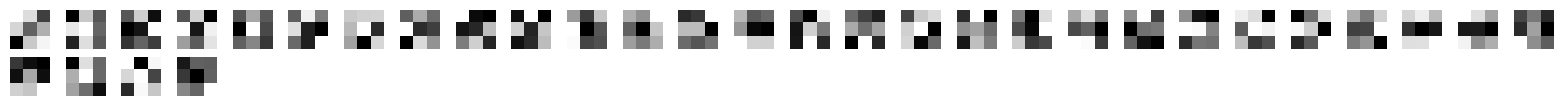

2-th Conv Layer:


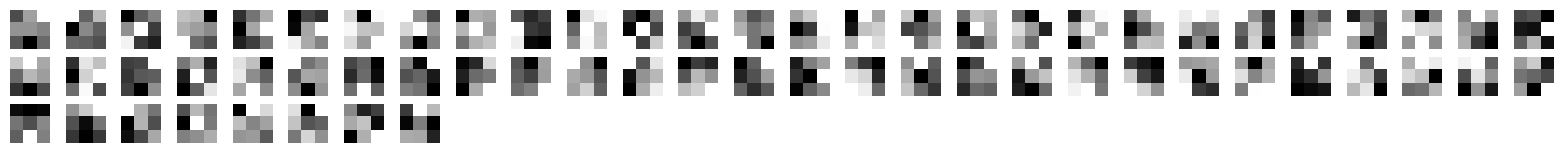

In [106]:
for i, weight in enumerate(conv_layers_weights, start=1):
    print(f"{i}-th Conv Layer:")
    plot_filters(weight)

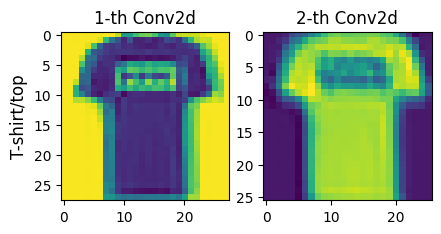

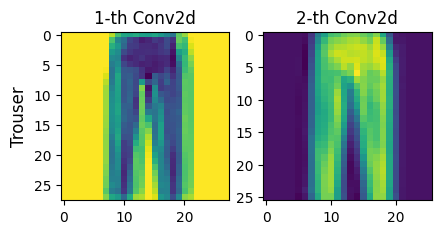

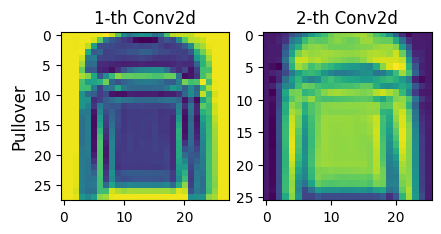

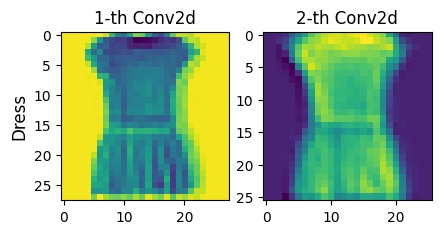

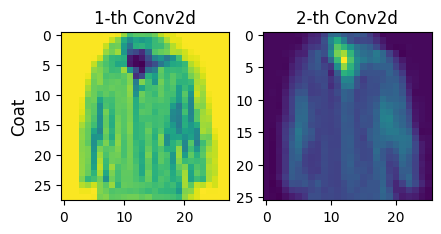

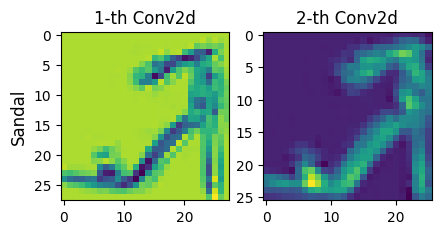

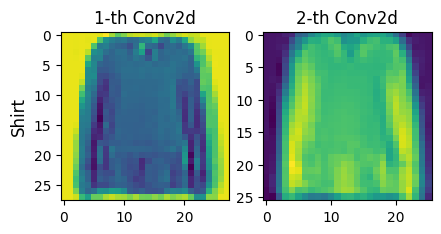

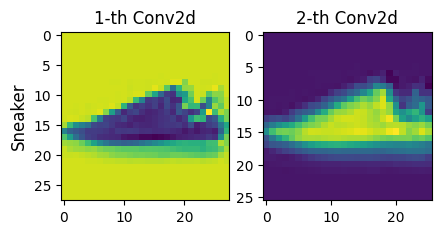

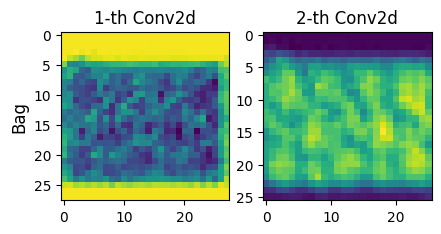

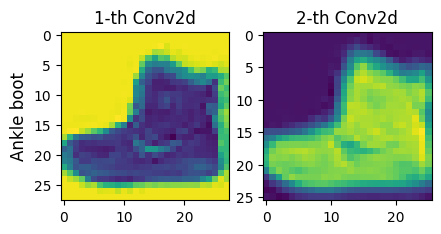

<Figure size 640x480 with 0 Axes>

In [131]:
for label in range(10):
    image = sampled_images[label][0].unsqueeze(0) # Add a batch dimension
    feature_maps = get_feature_maps(image, conv_layers)
    # plot_feature_maps(feature_maps, layer_names, labels_map)
    fig = plt.figure(figsize=(10, 20))
    for i, (feature_map, layer_name) in enumerate(zip(feature_maps, layer_names), start=0):
        a = fig.add_subplot(5, 4, i+1)
        imgplot = plt.imshow(feature_map)
        # a.axis("off")
        _ = a.set_title(f"{i+1}-th {layer_name.split('(')[0]}")
        if i == 0:
            _ = a.set_ylabel(f"{labels_map[label]}", fontsize=12)
plt.show()
plt.tight_layout();

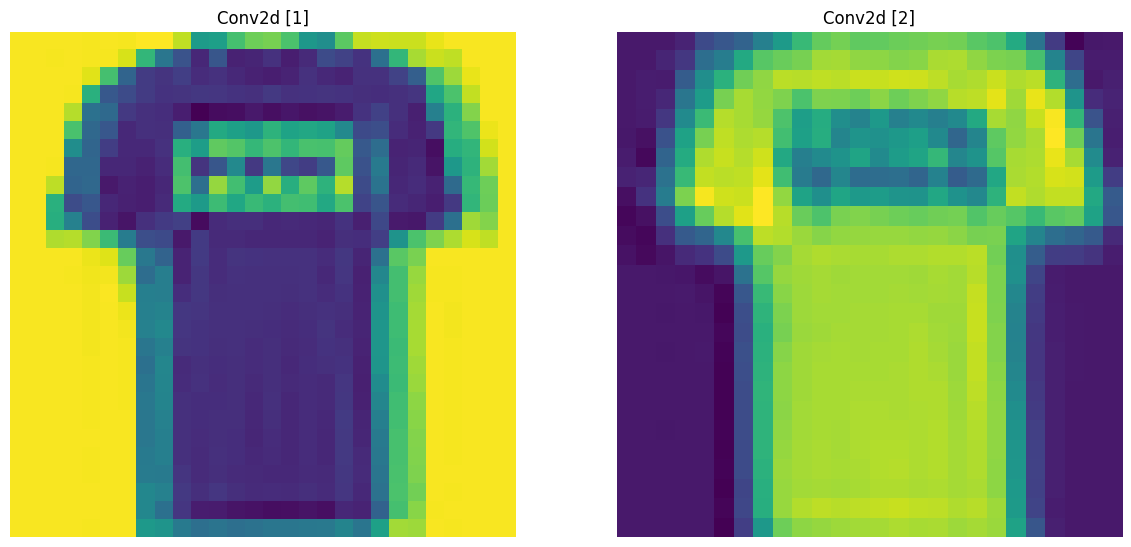

# 7. Test models
* FashionMLP
* FashionCNN
* Finetuned FashionCNN

In [ ]:
def test(trained_model, test_loader, best_model_save_path):
    print("Best model: ", best_model_save_path)

    # Calculate test score
    trained_model.load_state_dict(torch.load(best_model_save_path))
    trained_model = trained_model.to(device)
    trained_model.eval()

    running_test_loss = 0
    test_correct = 0
    test_y_true = []
    test_y_pred = []

    with torch.no_grad():
        for test_images, test_labels in test_loader:

            # Send images and labels to GPU if available
            test_images, test_labels = test_images.to(device), test_labels.to(device)

            # Cast dtype to torch.float (from unsigned char)
            test_images = test_images.view(test_images.size(0), 1, 28, 28).to(torch.float)

            # Inference
            test_outputs = trained_model(test_images)
            _, test_predicted = torch.max(test_outputs.detach(), 1)
            test_correct += (test_predicted == test_labels).sum().item()

            # Collect predictions and labels for metrics calculation
            test_y_true.extend(test_labels.cpu().numpy())
            test_y_pred.extend(test_predicted.cpu().numpy())


    # Calculate metrics
    test_accuracy = test_correct / len(test_loader.dataset)
    test_precision = precision_score(test_y_true, test_y_pred, average='macro', zero_division=0)
    test_recall = recall_score(test_y_true, test_y_pred, average='macro', zero_division=0)
    test_f1 = f1_score(test_y_true, test_y_pred, average='macro', zero_division=0)
    test_report_dict = get_classification_report_dict(test_y_true, test_y_pred)

    # Print results
    print(classification_report(test_y_true, test_y_pred))
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"Test Precision: {test_precision:.4f}")
    print(f"Test Recall: {test_recall:.4f}")
    print(f"Test F1: {test_f1:.4f}")

    plot_confusion_matrix(test_y_true, test_y_pred, labels=None, figsize=(28, 14))
    del test_y_true, test_y_pred

    return test_report_dict

Best model:  PyTorch_models/FashionCNN__lr0.0005_batch200_epoch500_earlystop50
              precision    recall  f1-score   support

           0       0.88      0.87      0.88      1000
           1       0.99      0.98      0.99      1000
           2       0.87      0.89      0.88      1000
           3       0.90      0.94      0.92      1000
           4       0.87      0.90      0.89      1000
           5       0.98      0.98      0.98      1000
           6       0.82      0.75      0.78      1000
           7       0.95      0.98      0.97      1000
           8       0.98      0.98      0.98      1000
           9       0.98      0.96      0.97      1000

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000

Test Accuracy: 0.9239
Test Precision: 0.9234
Test Recall: 0.9239
Test F1: 0.9233


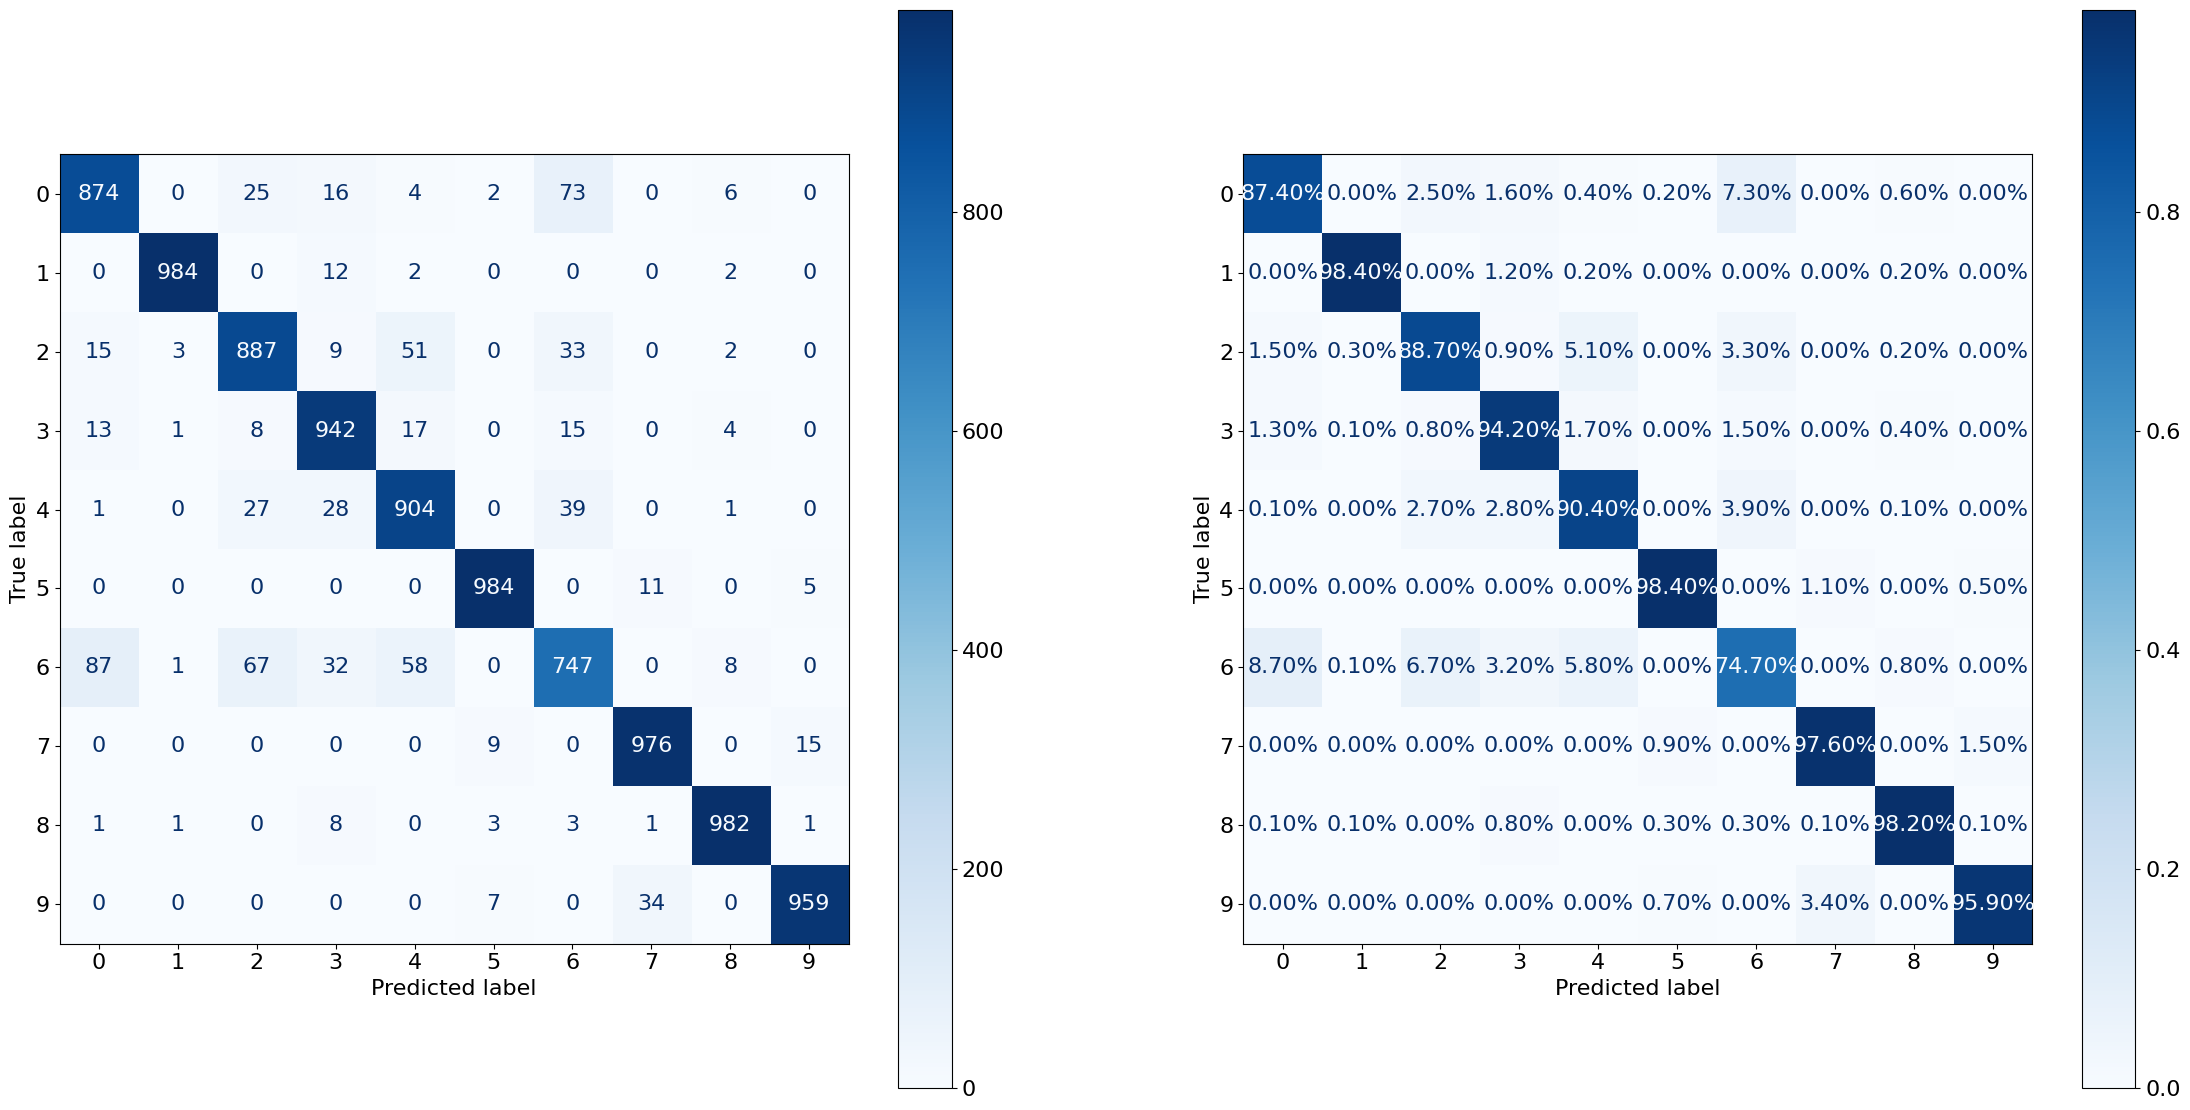

In [ ]:
best_model_save_path = f"PyTorch_models/{model.__class__.__name__}__lr{hyperparameters.learning_rate}_batch{hyperparameters.batch_size}_epoch{hyperparameters.num_epochs}_earlystop{hyperparameters.max_early_stop}"
test_report_dict = test(FashionCNN(), test_loader, best_model_save_path)

Best model:  PyTorch_models/FashionCNN_fold4_lr0.0001_batch150_epoch500_earlystop50
              precision    recall  f1-score   support

           0       0.87      0.87      0.87      1000
           1       0.99      0.98      0.99      1000
           2       0.88      0.87      0.88      1000
           3       0.92      0.93      0.92      1000
           4       0.86      0.90      0.88      1000
           5       0.99      0.97      0.98      1000
           6       0.78      0.76      0.77      1000
           7       0.95      0.97      0.96      1000
           8       0.98      0.98      0.98      1000
           9       0.97      0.97      0.97      1000

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000

Test Accuracy: 0.9202
Test Precision: 0.9202
Test Recall: 0.9202
Test F1: 0.9201


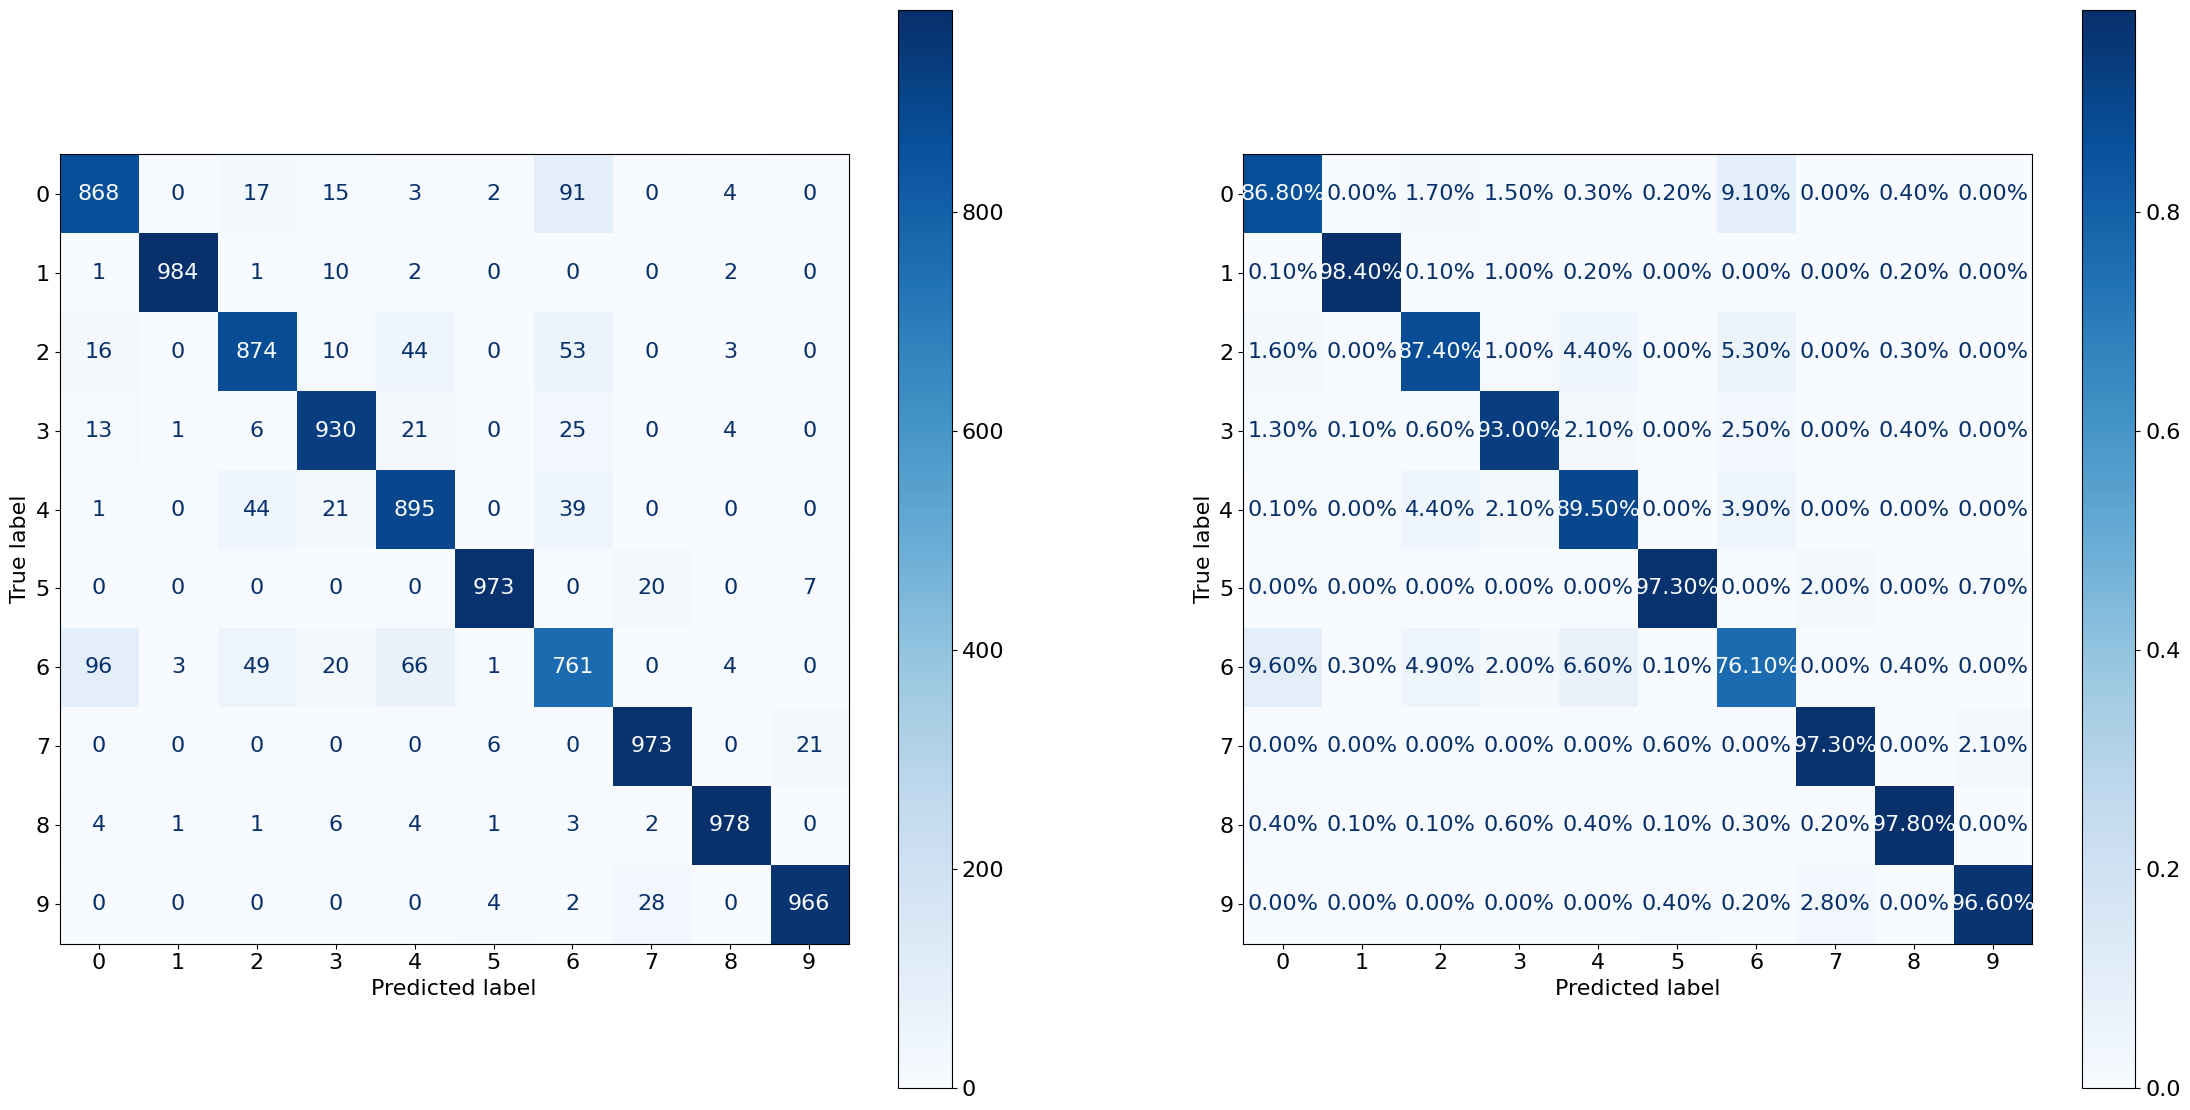

In [ ]:
test_report_dict = test(FashionCNN(), test_loader, "PyTorch_models/FashionCNN_fold4_lr0.0001_batch150_epoch500_earlystop50")

Best model:  PyTorch_models/FashionCNN_fold4_lr0.001_batch150_epoch500_earlystop50
              precision    recall  f1-score   support

           0       0.83      0.86      0.85      1000
           1       0.99      0.97      0.98      1000
           2       0.88      0.78      0.83      1000
           3       0.88      0.91      0.89      1000
           4       0.78      0.86      0.82      1000
           5       0.97      0.97      0.97      1000
           6       0.73      0.68      0.70      1000
           7       0.95      0.94      0.94      1000
           8       0.95      0.98      0.97      1000
           9       0.95      0.96      0.96      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000

Test Accuracy: 0.8917
Test Precision: 0.8918
Test Recall: 0.8917
Test F1: 0.8910


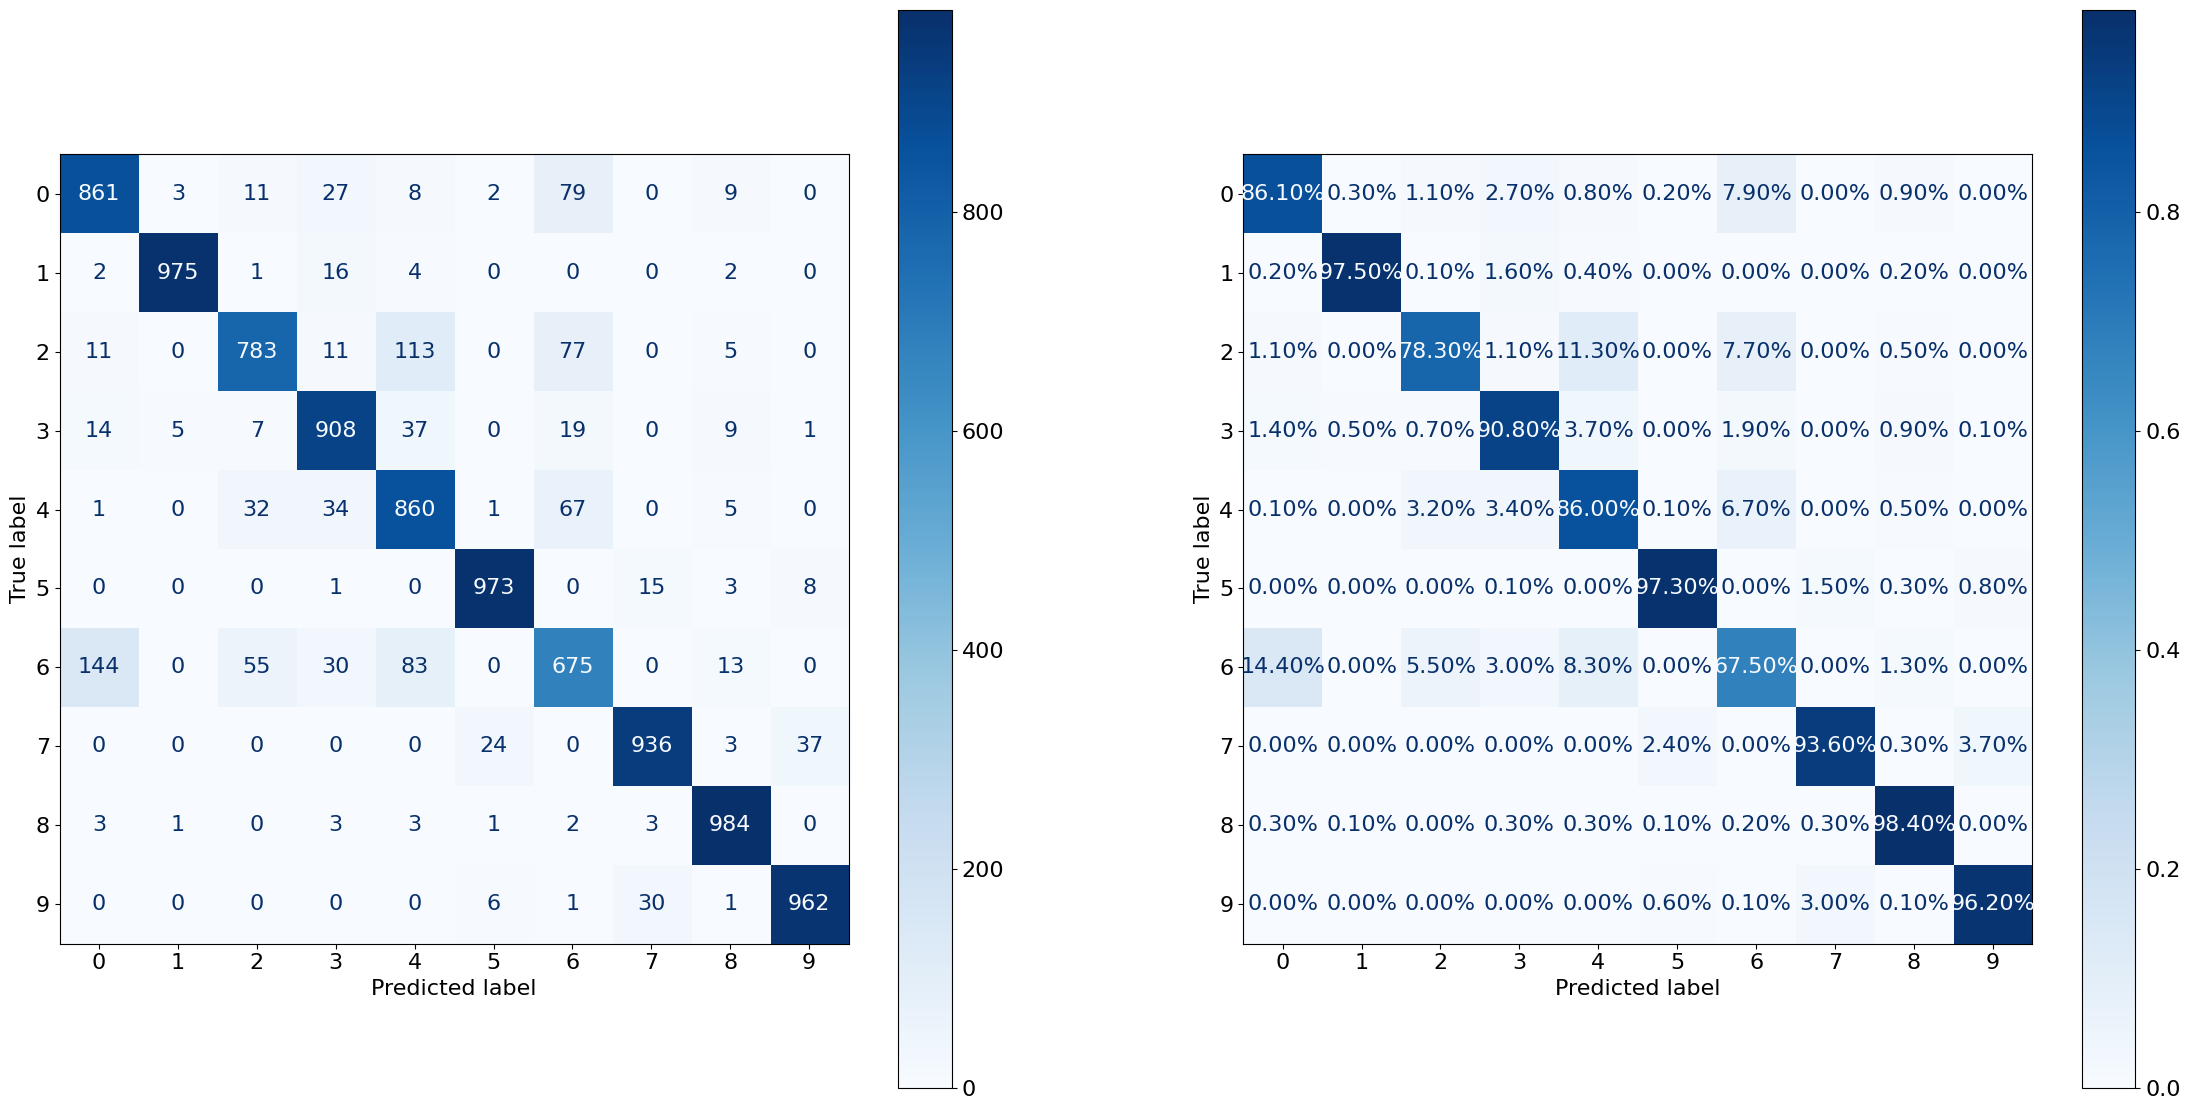

In [ ]:
# TODO: Define the save paths of the best models
# trained_model = FashionCNN()
test_report_dict = test(FashionCNN(), test_loader, "PyTorch_models/FashionCNN_fold4_lr0.001_batch150_epoch500_earlystop50")

In [ ]:
# TODO: Define the save paths of the best models
trained_model = FashionCNN()
test_report_dict = test(trained_model, test_loader, "PyTorch_models/FashionCNN_fold4_lr0.001_batch100_epoch3000_earlystop100")

Best model:  PyTorch_models/FashionCNN_fold4_lr0.001_batch100_epoch3000_earlystop100


RuntimeError: ignored